# Tutorial 4 - Working with PAGA and velocyto

## Load required packages

In [1]:
import os
import sys
import re
import copy
import loompy
import glob
import igraph
import sklearn as sk
import scipy as sp
import velocyto as vcy
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from igraph import *
from numpy_groupies import aggregate, aggregate_np
from matplotlib import colors

In [2]:
pwd = os.getcwd()

In [3]:
pwd

'/home/ktrav/BIOC281/Classes/4'

## PAGA

By quantifying the connectivity of partitions (groups, clusters) of the single-cell graph, partition-based graph abstraction (PAGA) generates a much simpler abstracted graph (PAGA graph) of partitions, in which edge weights represent confidence in the presence of connections.

See https://scanpy.readthedocs.io/en/stable/api/scanpy.tl.paga.html for more usage information

### Data ingest

In [4]:
# Read in the loom file with scanpy as we did the h5ad file from last week
adata = sc.read_loom(os.path.join(pwd, "MACA_bonemarrow_10x.loom"))

# The loom file came from velocyto's preprocessing tool, which splits the UMIs
# into three groups: those from spliced transcripts, unspliced transcripts
# those that are ambiguous. By default .X is set to the spliced UMIs,
# we reset that here to include all UMIs for PAGA
adata.X = adata.layers["matrix"].copy()

# Create a gene metadata column called 'Gene' that stores the gene symbols
# This is for velocyto later
adata.var['Gene'] = adata.var.index

adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 3427 × 52550
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'Gene'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [5]:
# Read in the cellular metadata
adata.obs = pd.read_csv(os.path.join(pwd, "MACA_bonemarrow_10x_metadata.txt"),
                        index_col=3,
                        delimiter="\t")

# Remove an unused index column
adata.obs.drop('phenotype', axis=1, inplace=True)

# Rename the columns "order" and "loomID" metadata columns to more informative names
adata.obs.rename({'order': 'free_annotation', 'loomID': 'cluster'}, axis=1, inplace=True)

# Create a cell metadata column called 'CellID' that stores the cell names
# This is for velocyto later
adata.obs['CellID'] = adata.obs.index

# Creates a cell metadata column called "SampleID" that stores the 10x channel
# each cell came from. We. use the sub() function from the re library to obtain
# the channel information with a list comprehension loop
adata.obs['SampleID'] = [re.sub('^(10X_P[0-9]{1,2}_[0-9]{1,2})_possorted_genome_.*$', '\\1', i) for i in adata.obs.index]
adata.obs

free_annotation  \
10X_P7_3_possorted_genome_EKX5P:AAACCTGAGCATCATC     Monocyte_progenitors   
10X_P7_3_possorted_genome_EKX5P:AAACCTGCAGAGTGTG                Monocytes   
10X_P7_3_possorted_genome_EKX5P:AAACCTGGTCGAACAG     Monocyte_progenitors   
10X_P7_3_possorted_genome_EKX5P:AAACCTGTCACTTCAT         Stem_Progenitors   
10X_P7_3_possorted_genome_EKX5P:AAACGGGAGAAGGTTT             Granulocytes   
...                                                                   ...   
10X_P7_2_possorted_genome_79DGS:TTTGGTTCATCCGTGG             Granulocytes   
10X_P7_2_possorted_genome_79DGS:TTTGGTTGTCAGGACA  Granulocyte_progenitors   
10X_P7_2_possorted_genome_79DGS:TTTGGTTTCCGTACAA  Granulocyte_progenitors   
10X_P7_2_possorted_genome_79DGS:TTTGGTTTCCCAGGTG             Granulocytes   
10X_P7_2_possorted_genome_79DGS:TTTGTCATCGAATCCA               Immature_B   

                                                  cluster  \
10X_P7_3_possorted_genome_EKX5P:AAACCTGAGCATCATC        2   
10X_P7_3_possorted_genome_EKX5P:AAACCTGCAGAGTGTG        3   
10X_P7_3_possorted_genome_EKX5P:AAACCTGGTCGAACAG        2   
10X_P7_3_possorted_genome_EKX5P:AAACCTGTCACTTCAT        1   
10X_P7_3_possorted_genome_EKX5P:AAACGGGAGAAGGTTT        3   
...                                                   ...   
10X_P7_2_possorted_genome_79DGS:TTTGGTTCATCCGTGG        3   
10X_P7_2_possorted_genome_79DGS:TTTGGTTGTCAGGACA        2   
10X_P7_2_possorted_genome_79DGS:TTTGGTTTCCGTACAA        2   
10X_P7_2_possorted_genome_79DGS:TTTGGTTTCCCAGGTG        3   
10X_P7_2_possorted_genome_79DGS:TTTGTCATCGAATCCA        2   

                                                                                            CellID  \
10X_P7_3_possorted_genome_EKX5P:AAACCTGAGCATCATC  10X_P7_3_possorted_genome_EKX5P:AAACCTGAGCATCATC   
10X_P7_3_possorted_genome_EKX5P:AAACCTGCAGAGTGTG  10X_P7_3_possorted_genome_EKX5P:AAACCTGCAGAGTGTG   
10X_P7_3_possorted_genome_EKX5P:AAACCTGGTCGAACAG  10X_P7_3_possorted_genome_EKX5P:AAACCTGGTCGAACAG   
10X_P7_3_possorted_genome_EKX5P:AAACCTGTCACTTCAT  10X_P7_3_possorted_genome_EKX5P:AAACCTGTCACTTCAT   
10X_P7_3_possorted_genome_EKX5P:AAACGGGAGAAGGTTT  10X_P7_3_possorted_genome_EKX5P:AAACGGGAGAAGGTTT   
...                                                                                            ...   
10X_P7_2_possorted_genome_79DGS:TTTGGTTCATCCGTGG  10X_P7_2_possorted_genome_79DGS:TTTGGTTCATCCGTGG   
10X_P7_2_possorted_genome_79DGS:TTTGGTTGTCAGGACA  10X_P7_2_possorted_genome_79DGS:TTTGGTTGTCAGGACA   
10X_P7_2_possorted_genome_79DGS:TTTGGTTTCCGTACAA  10X_P7_2_possorted_genome_79DGS:TTTGGTTTCCGTACAA   
10X_P7_2_possorted_genome_79DGS:TTTGGTTTCCCAGGTG  10X_P7_2_possorted_genome_79DGS:TTTGGTTTCCCAGGTG   
10X_P7_2_possorted_genome_79DGS:TTTGTCATCGAATCCA  10X_P7_2_possorted_genome_79DGS:TTTGTCATCGAATCCA   

                                                  SampleID  
10X_P7_3_possorted_genome_EKX5P:AAACCTGAGCATCATC  10X_P7_3  
10X_P7_3_possorted_genome_EKX5P:AAACCTGCAGAGTGTG  10X_P7_3  
10X_P7_3_possorted_genome_EKX5P:AAACCTGGTCGAACAG  10X_P7_3  
10X_P7_3_possorted_genome_EKX5P:AAACCTGTCACTTCAT  10X_P7_3  
10X_P7_3_possorted_genome_EKX5P:AAACGGGAGAAGGTTT  10X_P7_3  
...                                                    ...  
10X_P7_2_possorted_genome_79DGS:TTTGGTTCATCCGTGG  10X_P7_2  
10X_P7_2_possorted_genome_79DGS:TTTGGTTGTCAGGACA  10X_P7_2  
10X_P7_2_possorted_genome_79DGS:TTTGGTTTCCGTACAA  10X_P7_2  
10X_P7_2_possorted_genome_79DGS:TTTGGTTTCCCAGGTG  10X_P7_2  
10X_P7_2_possorted_genome_79DGS:TTTGTCATCGAATCCA  10X_P7_2  

[3427 rows x 4 columns]

In [6]:
# Save a copy of adata for later subsetting
adata_raw = copy.deepcopy(adata)

In [7]:
# Keep only monocytes and granulocytes and their progenitors
# This simplifies the trajectory analysis so we can more easily
# apply all four tools across the same dataset
adata = adata[[i in ['Monocytes', 'Monocyte_progenitors', 'Stem_Progenitors', 'Granulocyte_progenitors', 'Granulocytes'] for i in list(adata.obs.free_annotation)]]
adata_raw = adata_raw[[i in ['Monocytes', 'Monocyte_progenitors', 'Stem_Progenitors', 'Granulocyte_progenitors', 'Granulocytes'] for i in list(adata_raw.obs.free_annotation)]]
adata

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 2343 × 52550
    obs: 'free_annotation', 'cluster', 'CellID', 'SampleID'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'Gene'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

### scanpy clustering

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


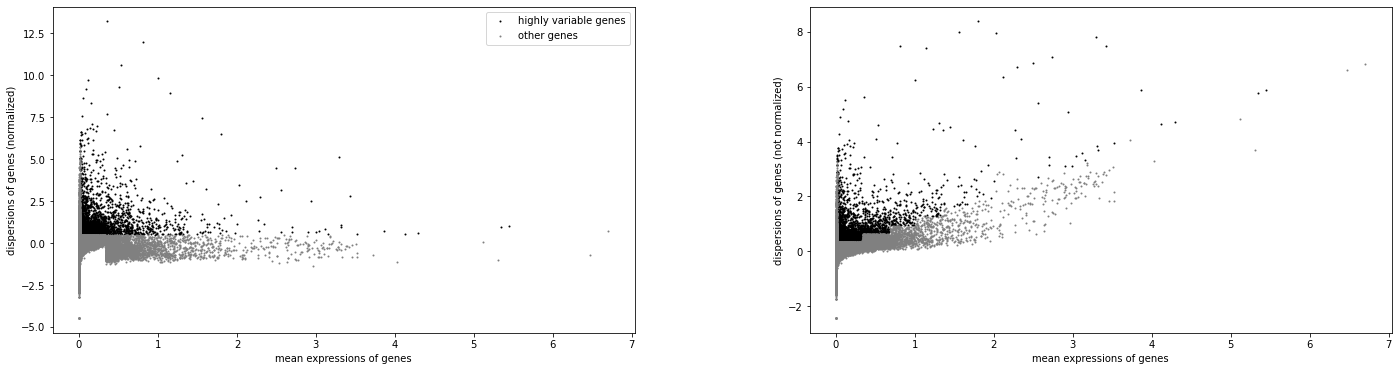

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


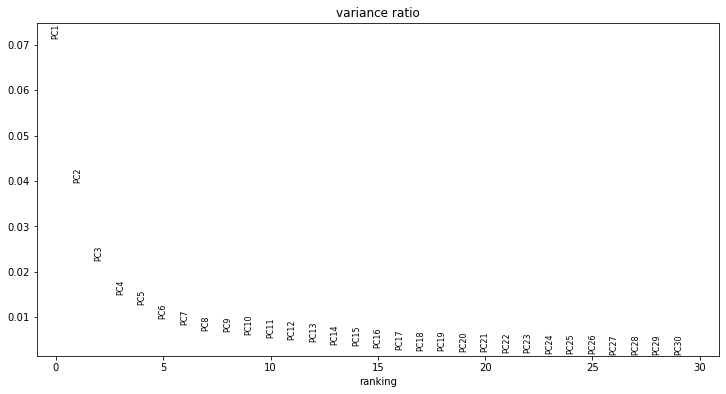

In [8]:
plt.rcParams['figure.figsize'] = [12, 6]

# Run through the boilerplate scanpy procedure from normalization
# to feature selection to principle component analysis from last week
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=30)
sc.pl.pca_variance_ratio(adata, n_pcs=30)

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'free_annotation' as categorical
... storing 'SampleID' as categorical
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
... storing 'Gene' as categorical


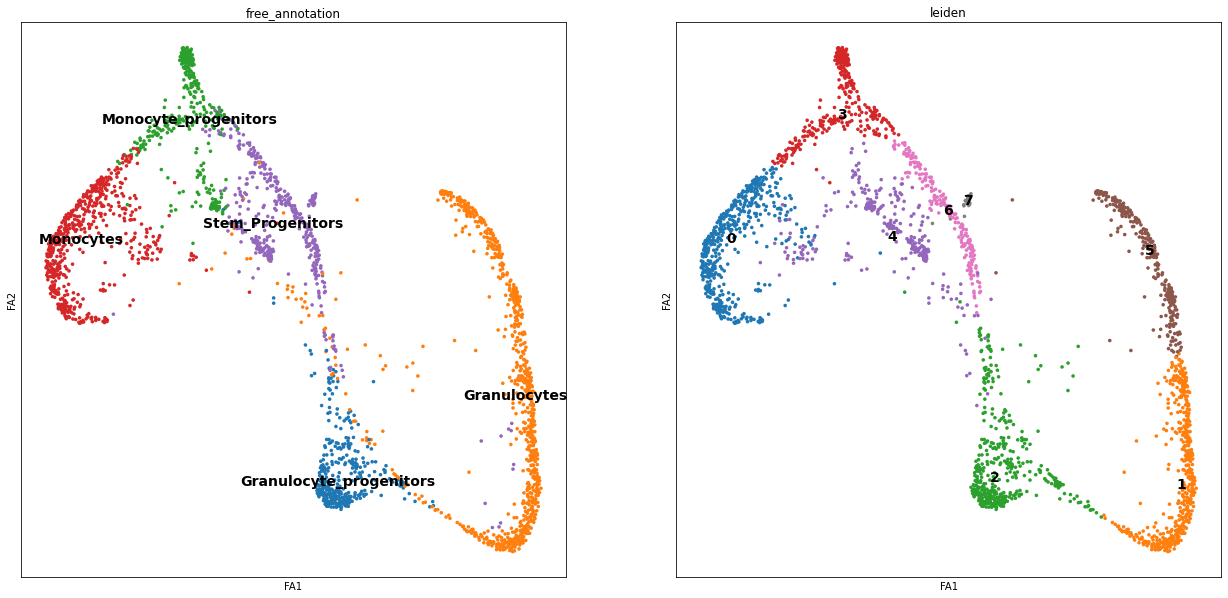

In [9]:
plt.rcParams['figure.figsize'] = [10, 10]

# Cluster the data using the same approach as last week
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=8)
sc.tl.leiden(adata, resolution=0.25)

# Reduce the principle compnents used in clustering down to 2 dimensions with the
# ForceAtlas2 algortithm. This step is conceptually similar to UMAP, but is 
# optimized for trajectories and dynamic processes. See Jacomy et al (2014) PLoS One
# For more information about the algorithm
sc.tl.draw_graph(adata)

# Plot cells based on their coordinates from ForceAtlas2, paint on the
# free_annotation's from MACA and the leiden clustering
sc.pl.draw_graph(adata, color=["free_annotation", "leiden"], legend_loc="on data", legend_fontsize=14)

**Question:** Do the Leiden clusters align with the cellular annotations?

**Answer:**

In [10]:
# Calculate genes enriched in each cellular annotation
sc.tl.rank_genes_groups(adata, groupby="free_annotation", method="wilcoxon")

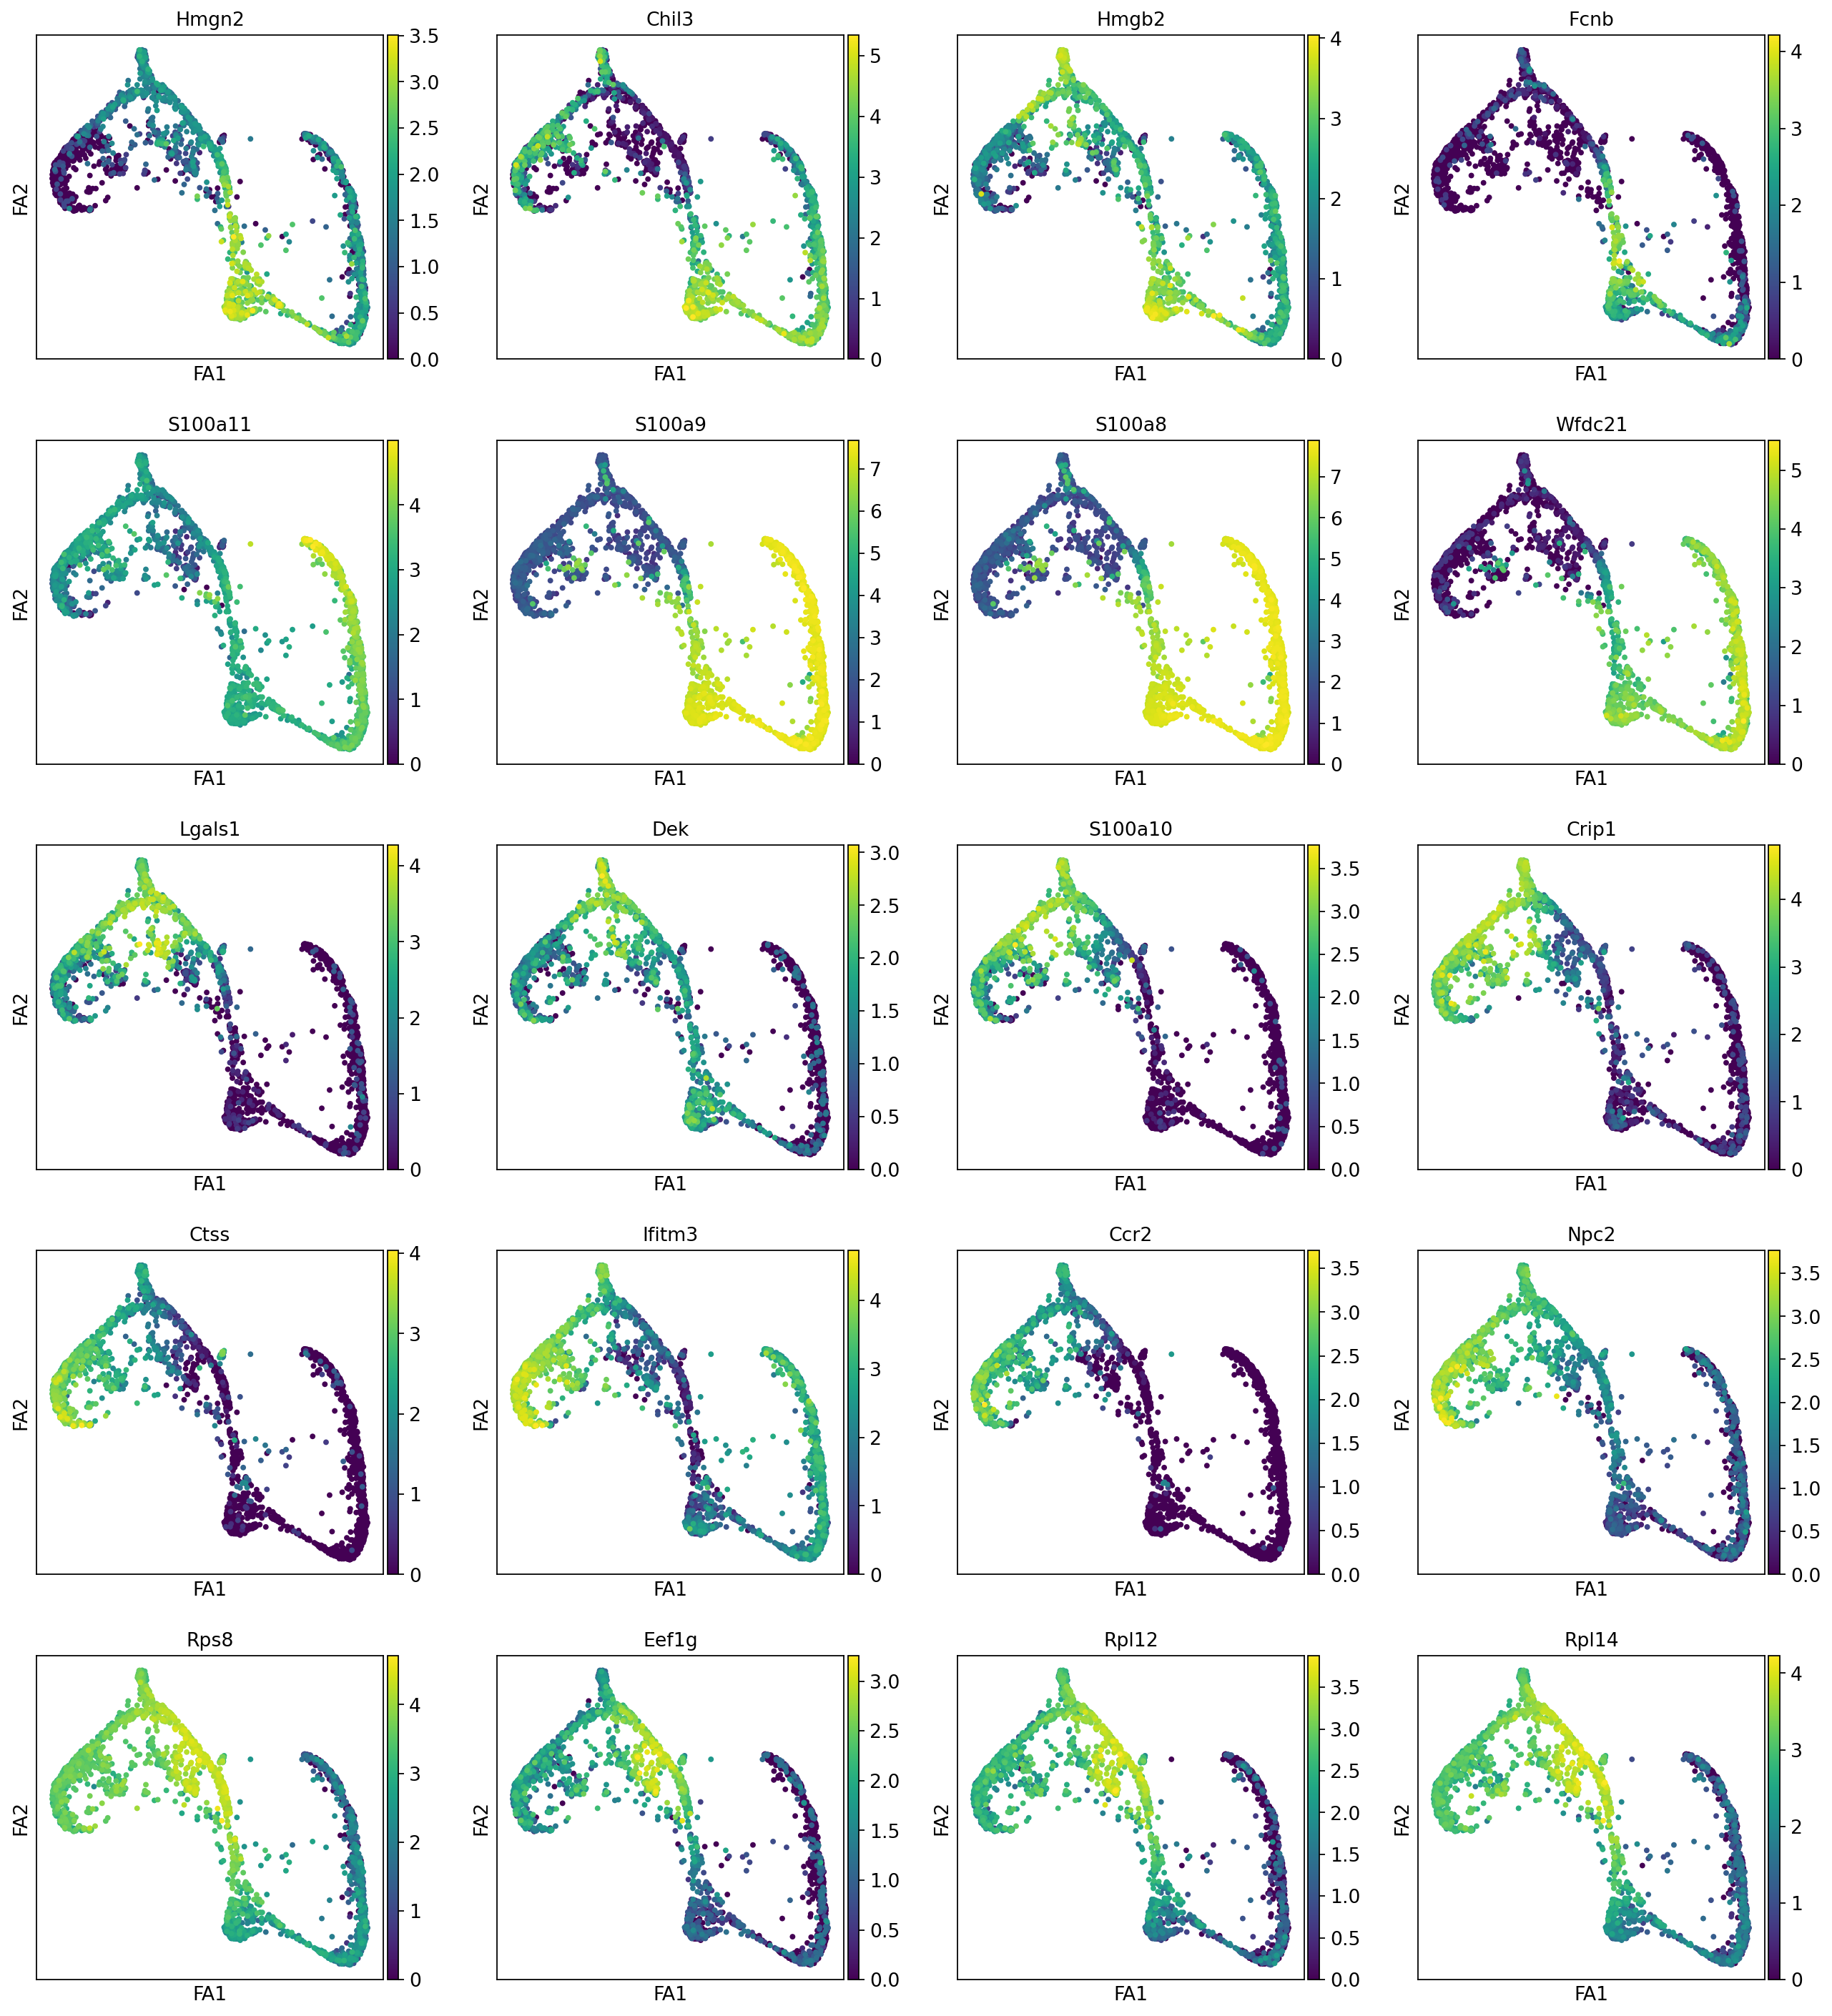

In [11]:
plt.rcParams['figure.figsize'] = [12, 12]
sc.set_figure_params(fontsize=12)

# Plot expression of 4 markers per annotation
sc.pl.draw_graph(adata, color=np.ravel(np.array(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(4).T)), size=50)

**Question:** Do any of the groups of genes identified seem to represent technical axes of variation? If so, which one and what is the artifact?

**Answer:**

In [12]:
# Calculate genes enriched in each leiden cluster
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

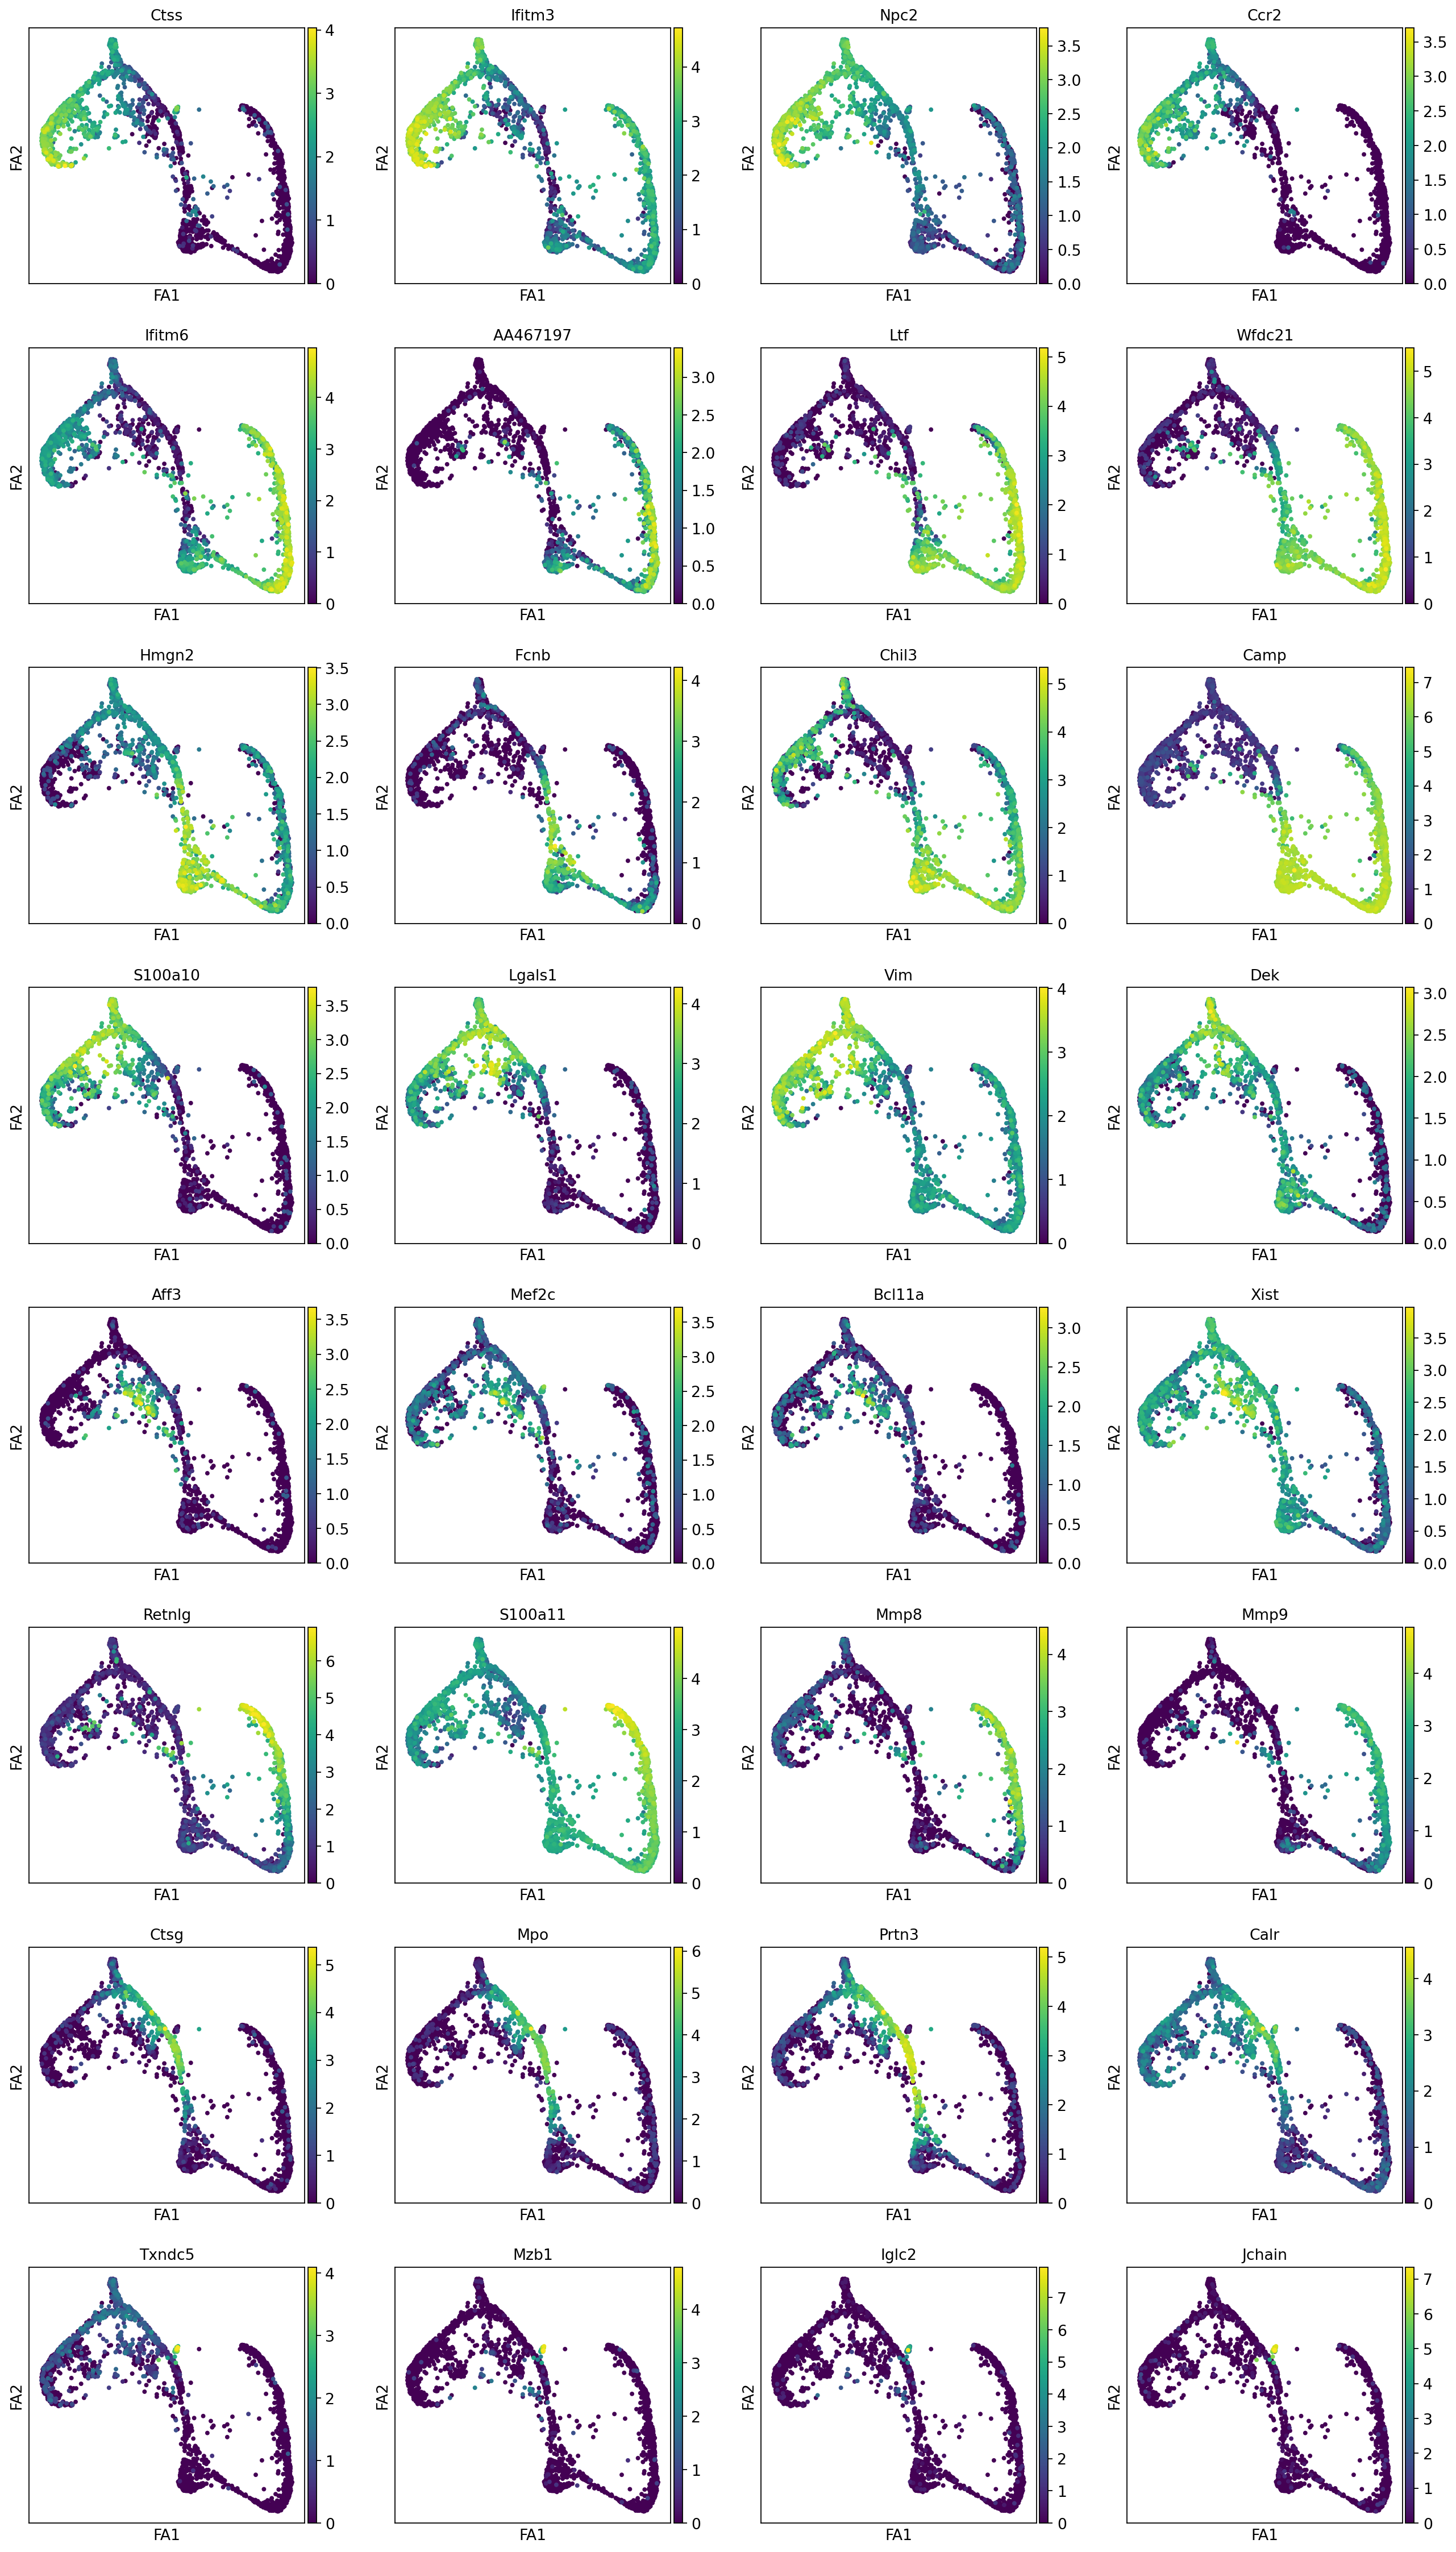

In [13]:
plt.rcParams['figure.figsize'] = [12, 12]
sc.set_figure_params(fontsize=12)

# Plot expression of 4 markers per cluster
sc.pl.draw_graph(adata, color=np.ravel(np.array(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(4).T)), size=50)

**Question:** Do any of the annotations seem to represent more than one cell type? If so, which one? 

**Answer:**

In [14]:
# Python dictionaries allow us to store information in keys, for exmaple:
# my_dict = {'key': value, 'science': 'is', 'really': 'fun'}
# my_dict['science'] will return "is" and my_dict['really'] will return "fun"
# In this case we'll use a dict where each "key" is a cell type and the information stored
# (the "value") is a data frame of differentially expressed genes for that cell type
marker_genes = {}

    
# Python has something called comprehension that allows for 1-liner loops
# In the simplest case, something like [print(x) for x in [1, 2, 3]] would print 1, 2 and 3 on separate lines.
# It is equivalent to
#
# for x in [1, 2, 3]:
#    print(x)
#
# In this case, we use two nested loops
# The inner loop, for key in ['names', 'pvals_adj', 'logfoldchanges'], pulls the gene symbols, adjusted p-values,
# and logfoldchanges from the differential gene expression results in the temporary adata object for each
# cell type, which is set by the outer loop, for group in groups. The outer loop then stores the results of the inner
# loop to a temporary dictionary with the cell types name as the key.
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
marker_genes = {group: pd.DataFrame({key: result[key][group] for key in ['names', 'pvals_adj', 'logfoldchanges']}) for group in groups}

In [15]:
# Plot the top 25 genes for any cluster, right now cluster 5 is shown
marker_genes['6'].iloc[:50,:]

names      pvals_adj  logfoldchanges
0      Ctsg  5.796435e-110        6.706317
1       Mpo  1.340744e-109        7.328441
2     Prtn3  1.025965e-106        6.212346
3      Calr  5.339586e-106        3.668770
4     Elane  8.446427e-104        7.071539
5      Cst7  6.352581e-101        5.117997
6      Rps8  6.048542e-100        2.190442
7      Rps2  9.260881e-100        2.730720
8    Atp5g1   4.039226e-98        2.612291
9    Rpl36a   1.738971e-96        2.714304
10    Eif5a   3.164653e-95        2.072886
11      Mif   5.473404e-95        3.824982
12    Rps17   6.310409e-95        2.126351
13    Ms4a3   1.201137e-94        5.005766
14    Rpl14   2.884620e-94        2.499508
15    Rps23   4.113448e-94        1.906801
16    Rpl11   8.001818e-94        1.834803
17  Rpl22l1   2.808970e-93        2.343177
18    Cmtm7   3.225597e-93        2.342320
19    Nop10   1.744867e-91        2.710039
20    Rps18   5.863042e-91        2.296341
21    Rpl41   9.514885e-91        1.600822
22    Rpl12   1.835067e-90        2.665338
23   Igfbp4   2.019453e-90        3.575298
24     Ssr4   2.019453e-90        2.418077
25    Rps25   2.930573e-90        1.496755
26      Srm   5.976192e-90        4.033912
27     Rpl8   6.304569e-90        1.871906
28    Eef1g   6.929718e-90        2.708867
29     Rps6   3.340862e-89        2.067014
30    Rpl32   5.224741e-89        2.069102
31    Rps12   8.630575e-89        2.008627
32    Rpl13   5.349566e-88        1.986149
33    Rps26   9.973042e-88        1.943556
34     Npm1   1.676639e-87        2.791495
35    Snrpf   3.163471e-87        2.408691
36     Cdk6   3.857423e-87        3.458986
37     Ssr2   4.400791e-87        2.647408
38     Rpl6   6.381449e-87        1.853487
39    Rps19   8.588588e-87        2.107841
40    Rpl28   1.013636e-86        1.865692
41    Pdia6   1.449997e-86        2.803457
42    Rpl31   1.605737e-86        1.666607
43   Atpif1   1.605737e-86        2.174747
44    Rpl35   1.605737e-86        2.073481
45     Nkg7   1.699093e-86        5.030150
46     Ybx1   1.806698e-86        1.810356
47    Phgdh   3.150720e-86        3.817926
48     Manf   3.378868e-86        2.614784
49     Rpl3   3.545174e-86        2.472692

**Question:** Are there clusters that appear off of the main trajectory from HSCs to either granulocytes or monocytes? Hint: Look at the first code block below.

**Answer**: 

### PAGA and pseudotime calculation

In [16]:
# If there are off-trajectory cells, remove them. If you want to remove clusters
# 4 and 7 change ['clusters', 'to', 'remove'] to ['4', '7']
adata = adata_raw[[i not in ['4', '7'] for i in list(adata.obs.leiden)]]

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


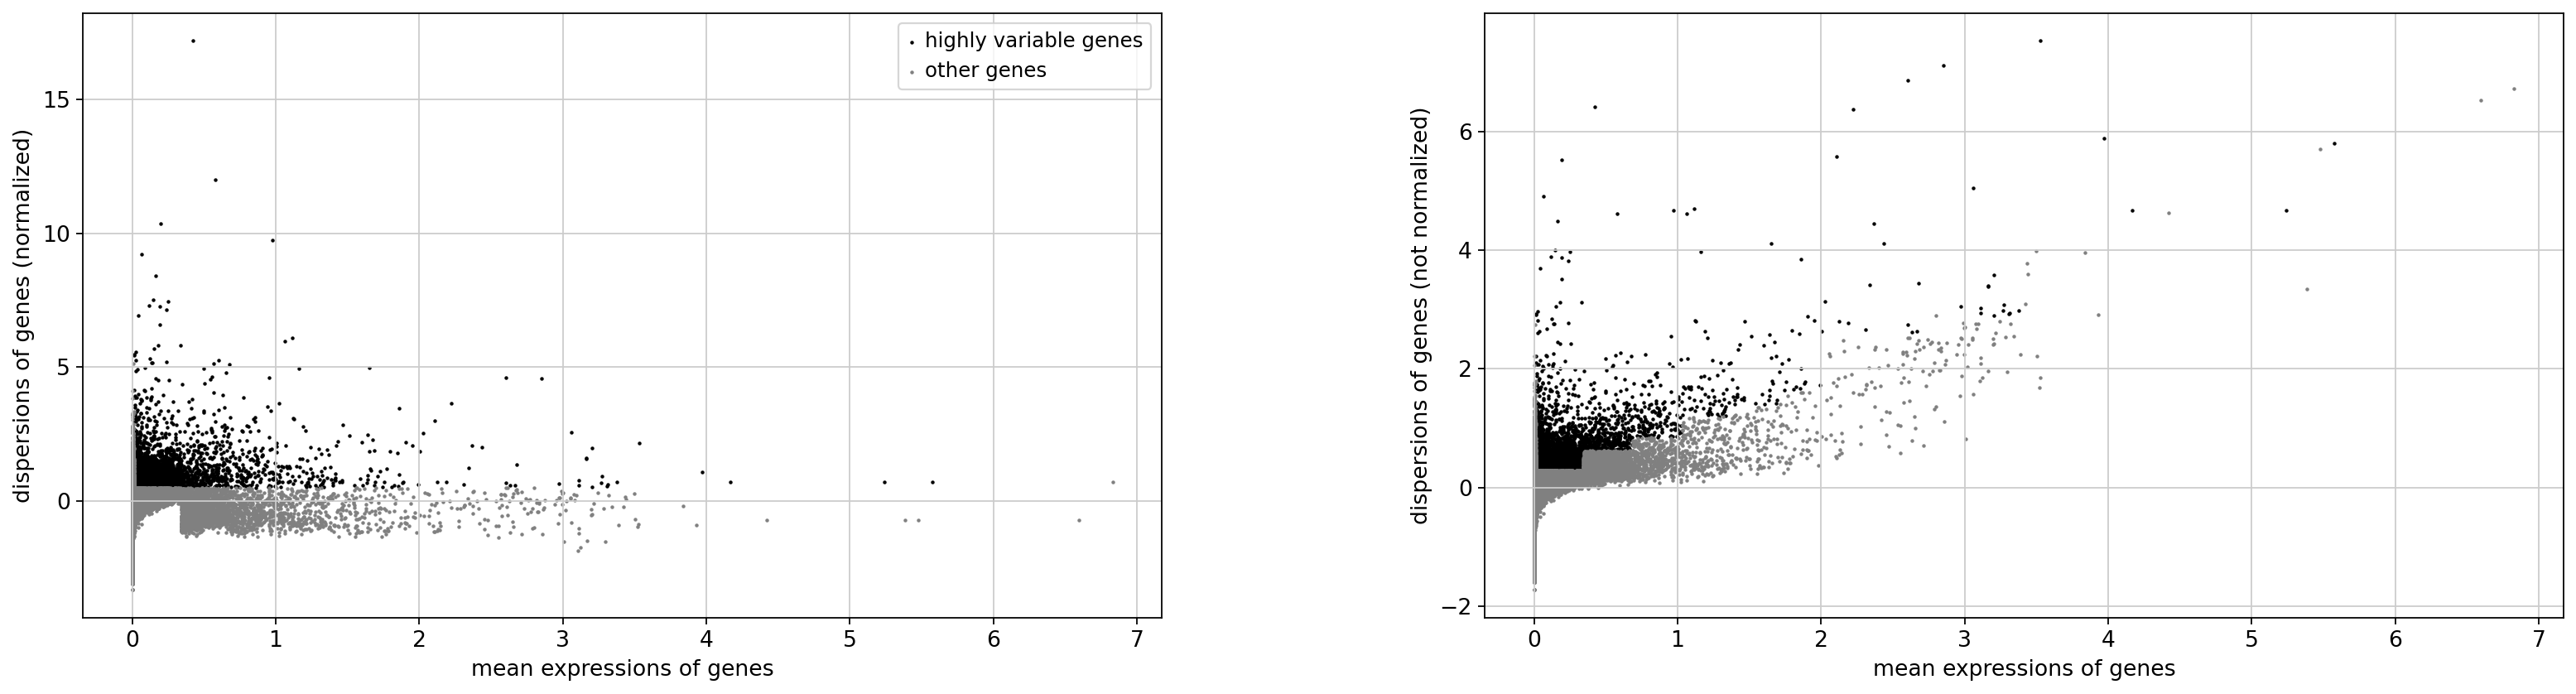

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


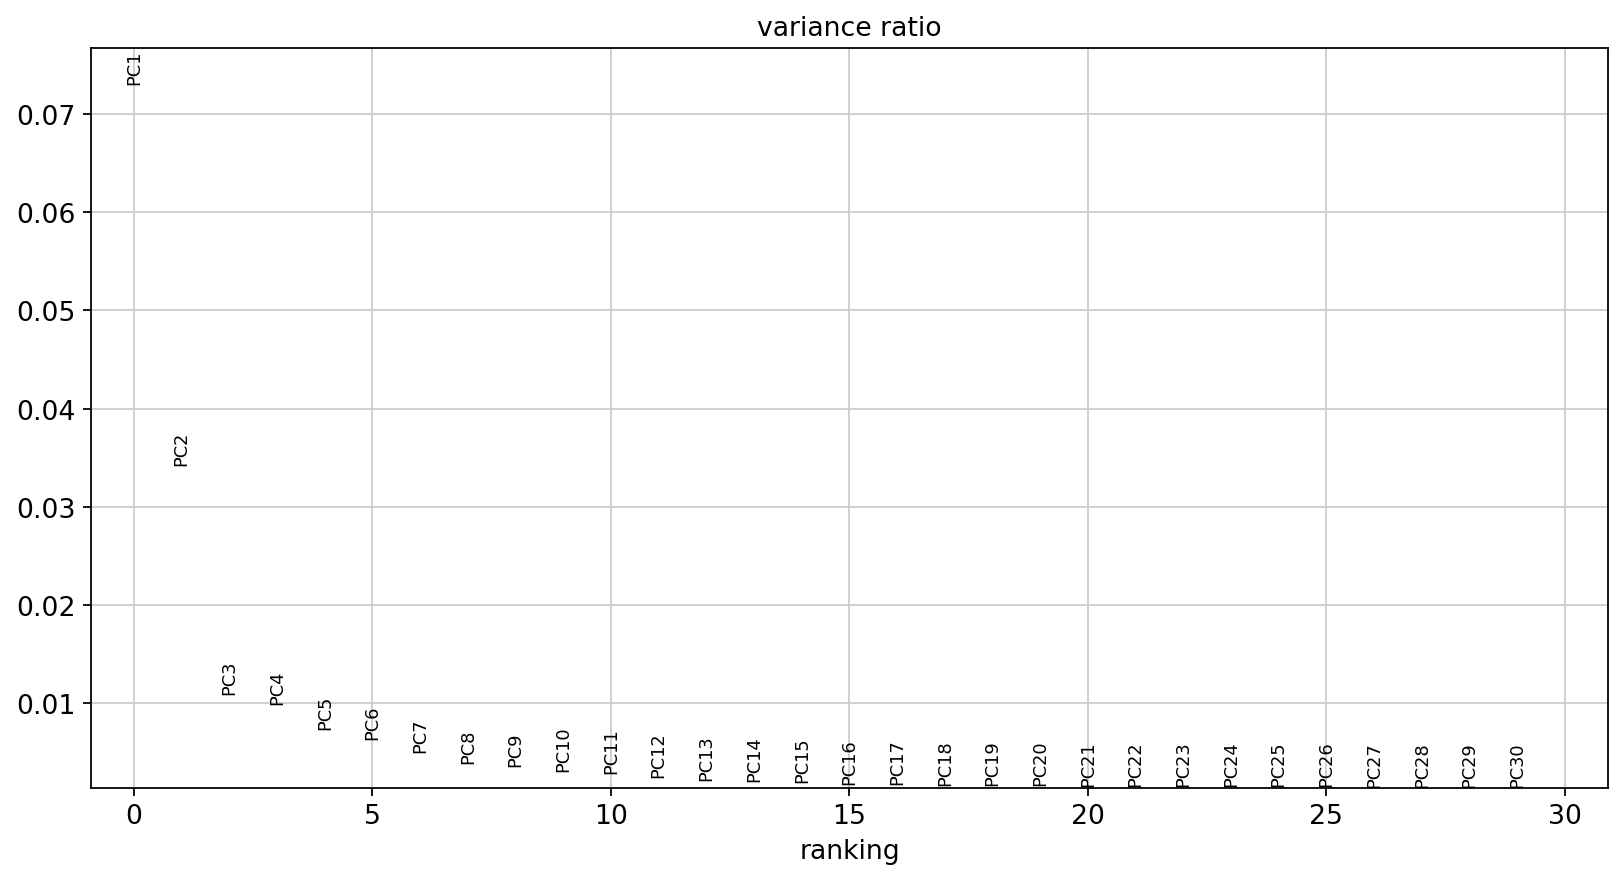

In [17]:
plt.rcParams['figure.figsize'] = [12, 6]

# Run through the boilerplate scanpy procedure from normalization
# to feature selection to principle component analysis from last week
# without the off-trajectory clusters
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=6, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack', n_comps=30)
sc.pl.pca_variance_ratio(adata, n_pcs=30)

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'free_annotation' as categorical
... storing 'SampleID' as categorical
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
... storing 'Gene' as categorical


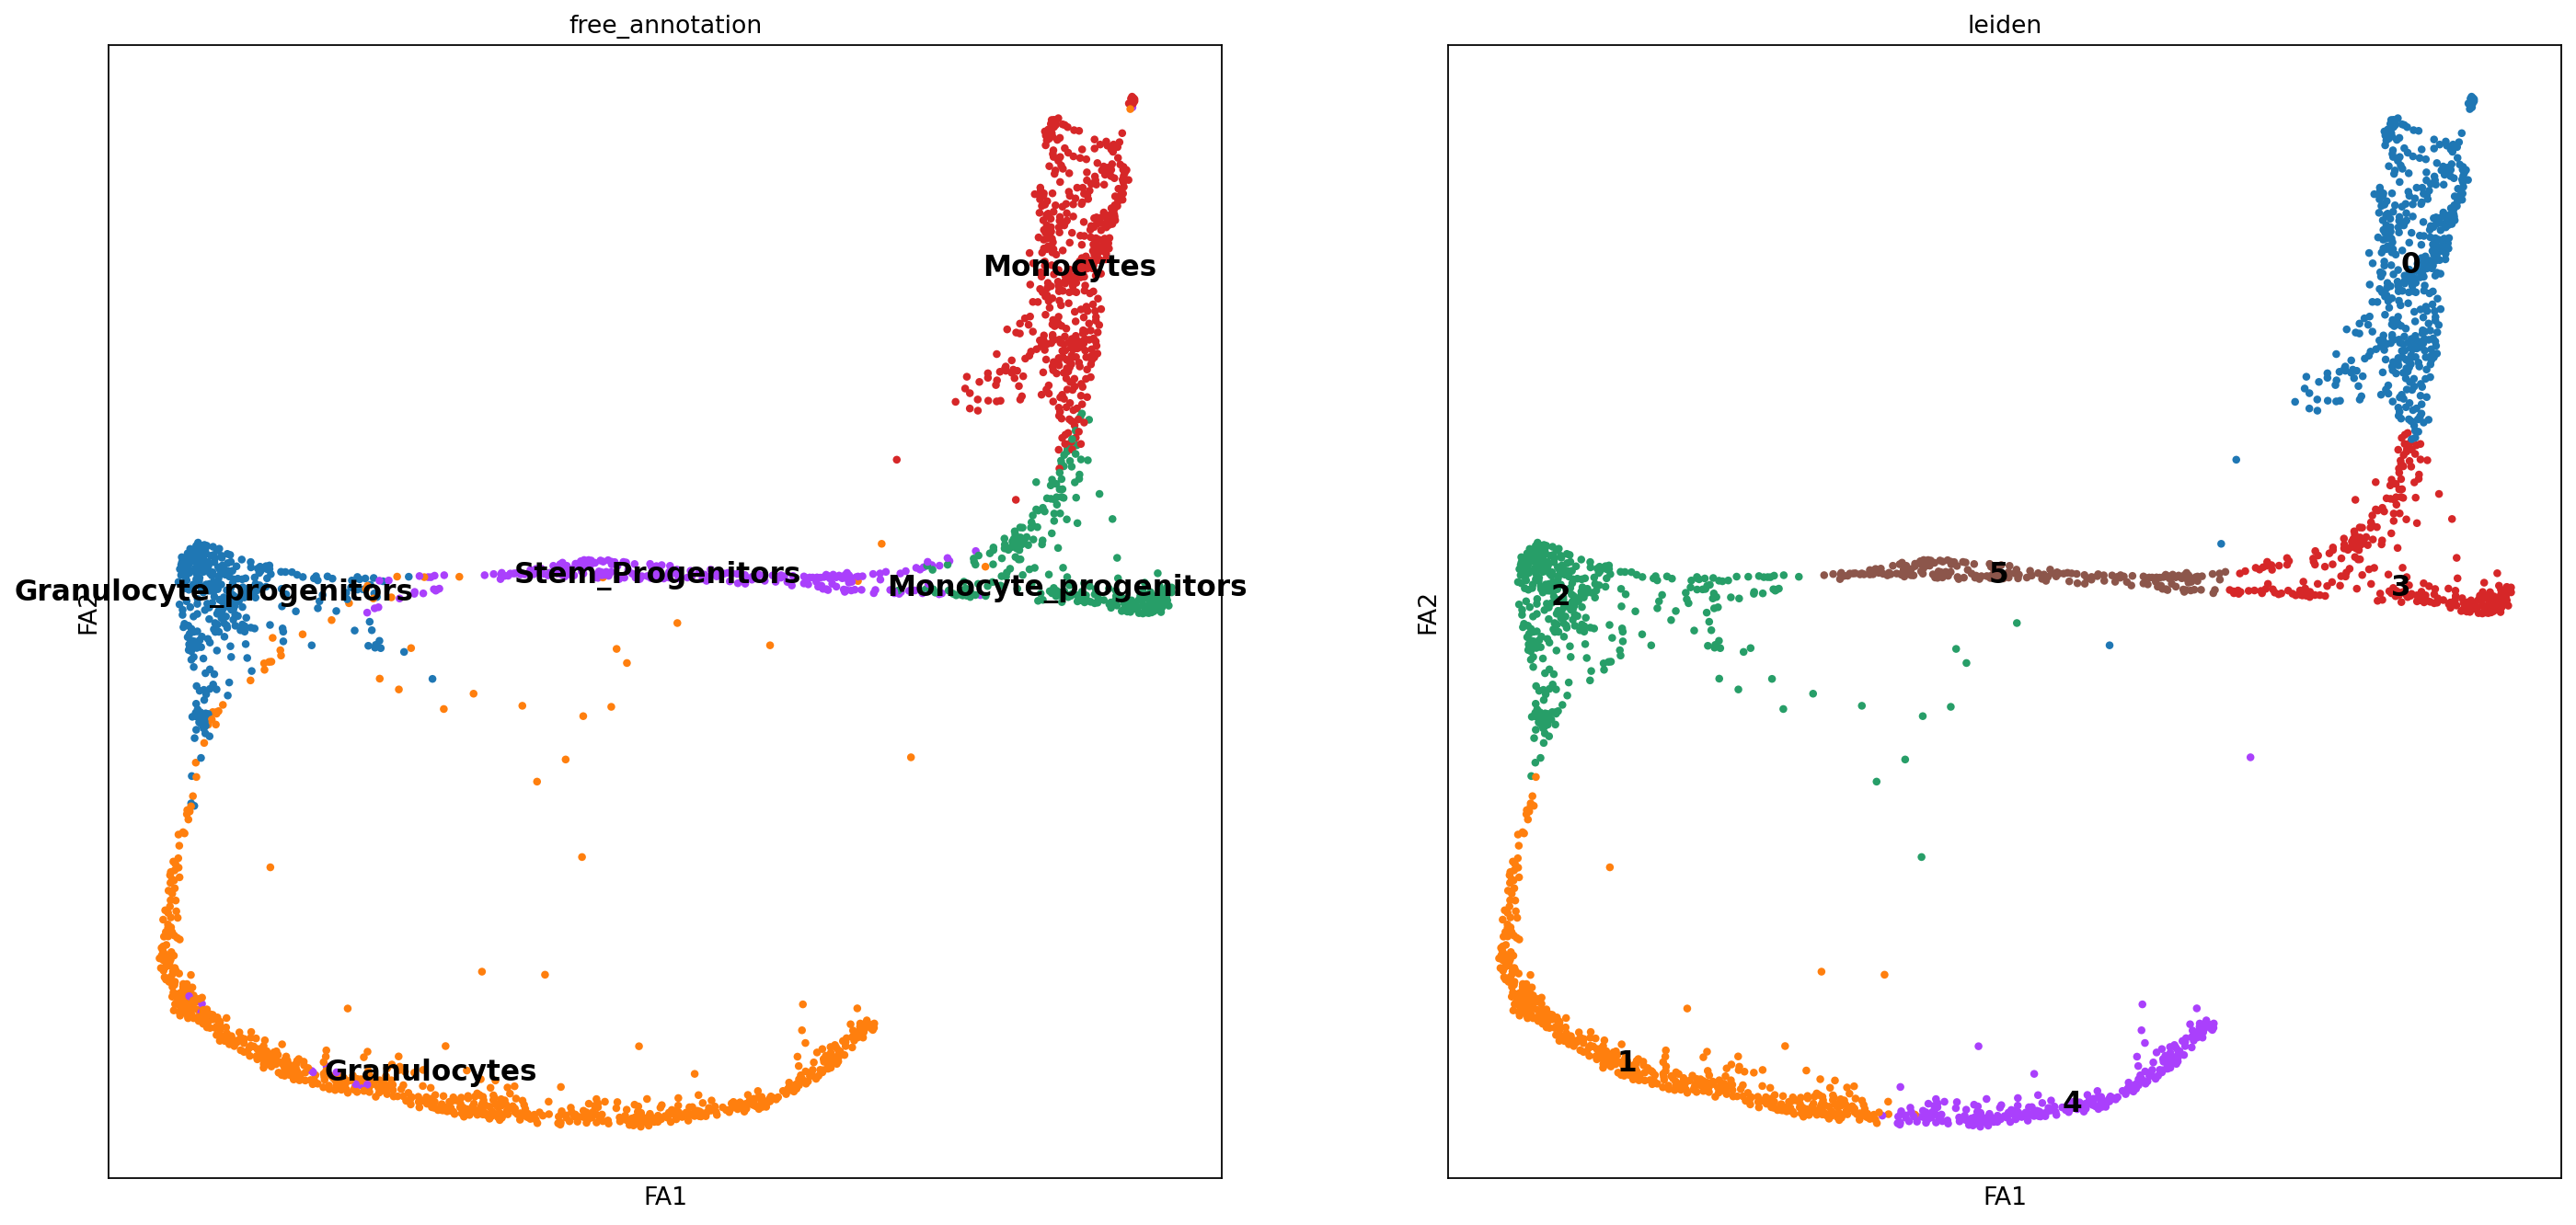

In [18]:
plt.rcParams['figure.figsize'] = [10, 10]

# Re-run neighbors, leiden, and ForceAtlas2 without the off-trajectory cells
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=7)
sc.tl.leiden(adata, resolution=0.25)
sc.tl.draw_graph(adata)

# Plot the cells with the new ForceAtlas2 coordinates
sc.pl.draw_graph(adata, color=["free_annotation", "leiden"], legend_loc="on data", legend_fontsize=14)

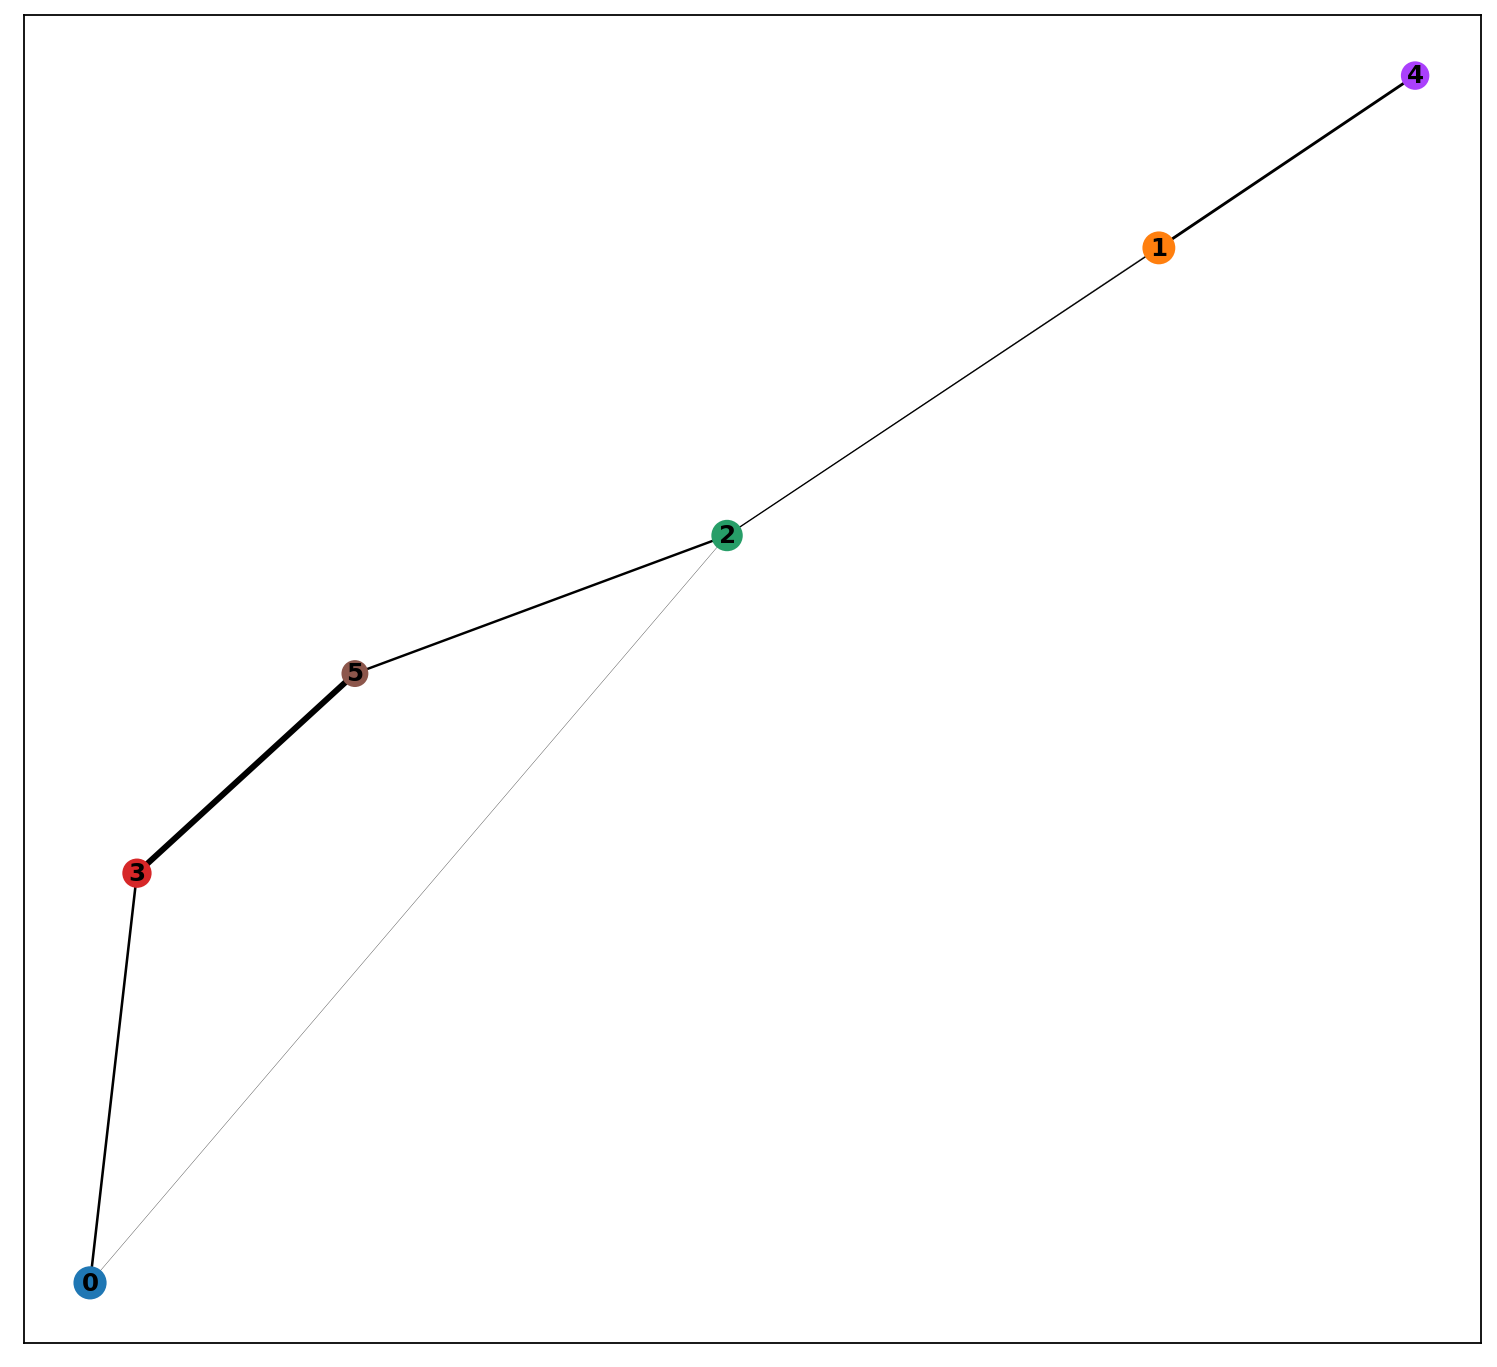

In [19]:
plt.rcParams['figure.figsize'] = [10, 10]

# Run PAGA, with it aware of the leiden clustering
# See. 
sc.tl.paga(adata, groups="leiden")

# Plot the relationships and their strengths between each cluster
sc.pl.paga(adata)

/home/ktrav/miniconda3/envs/singlecell/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


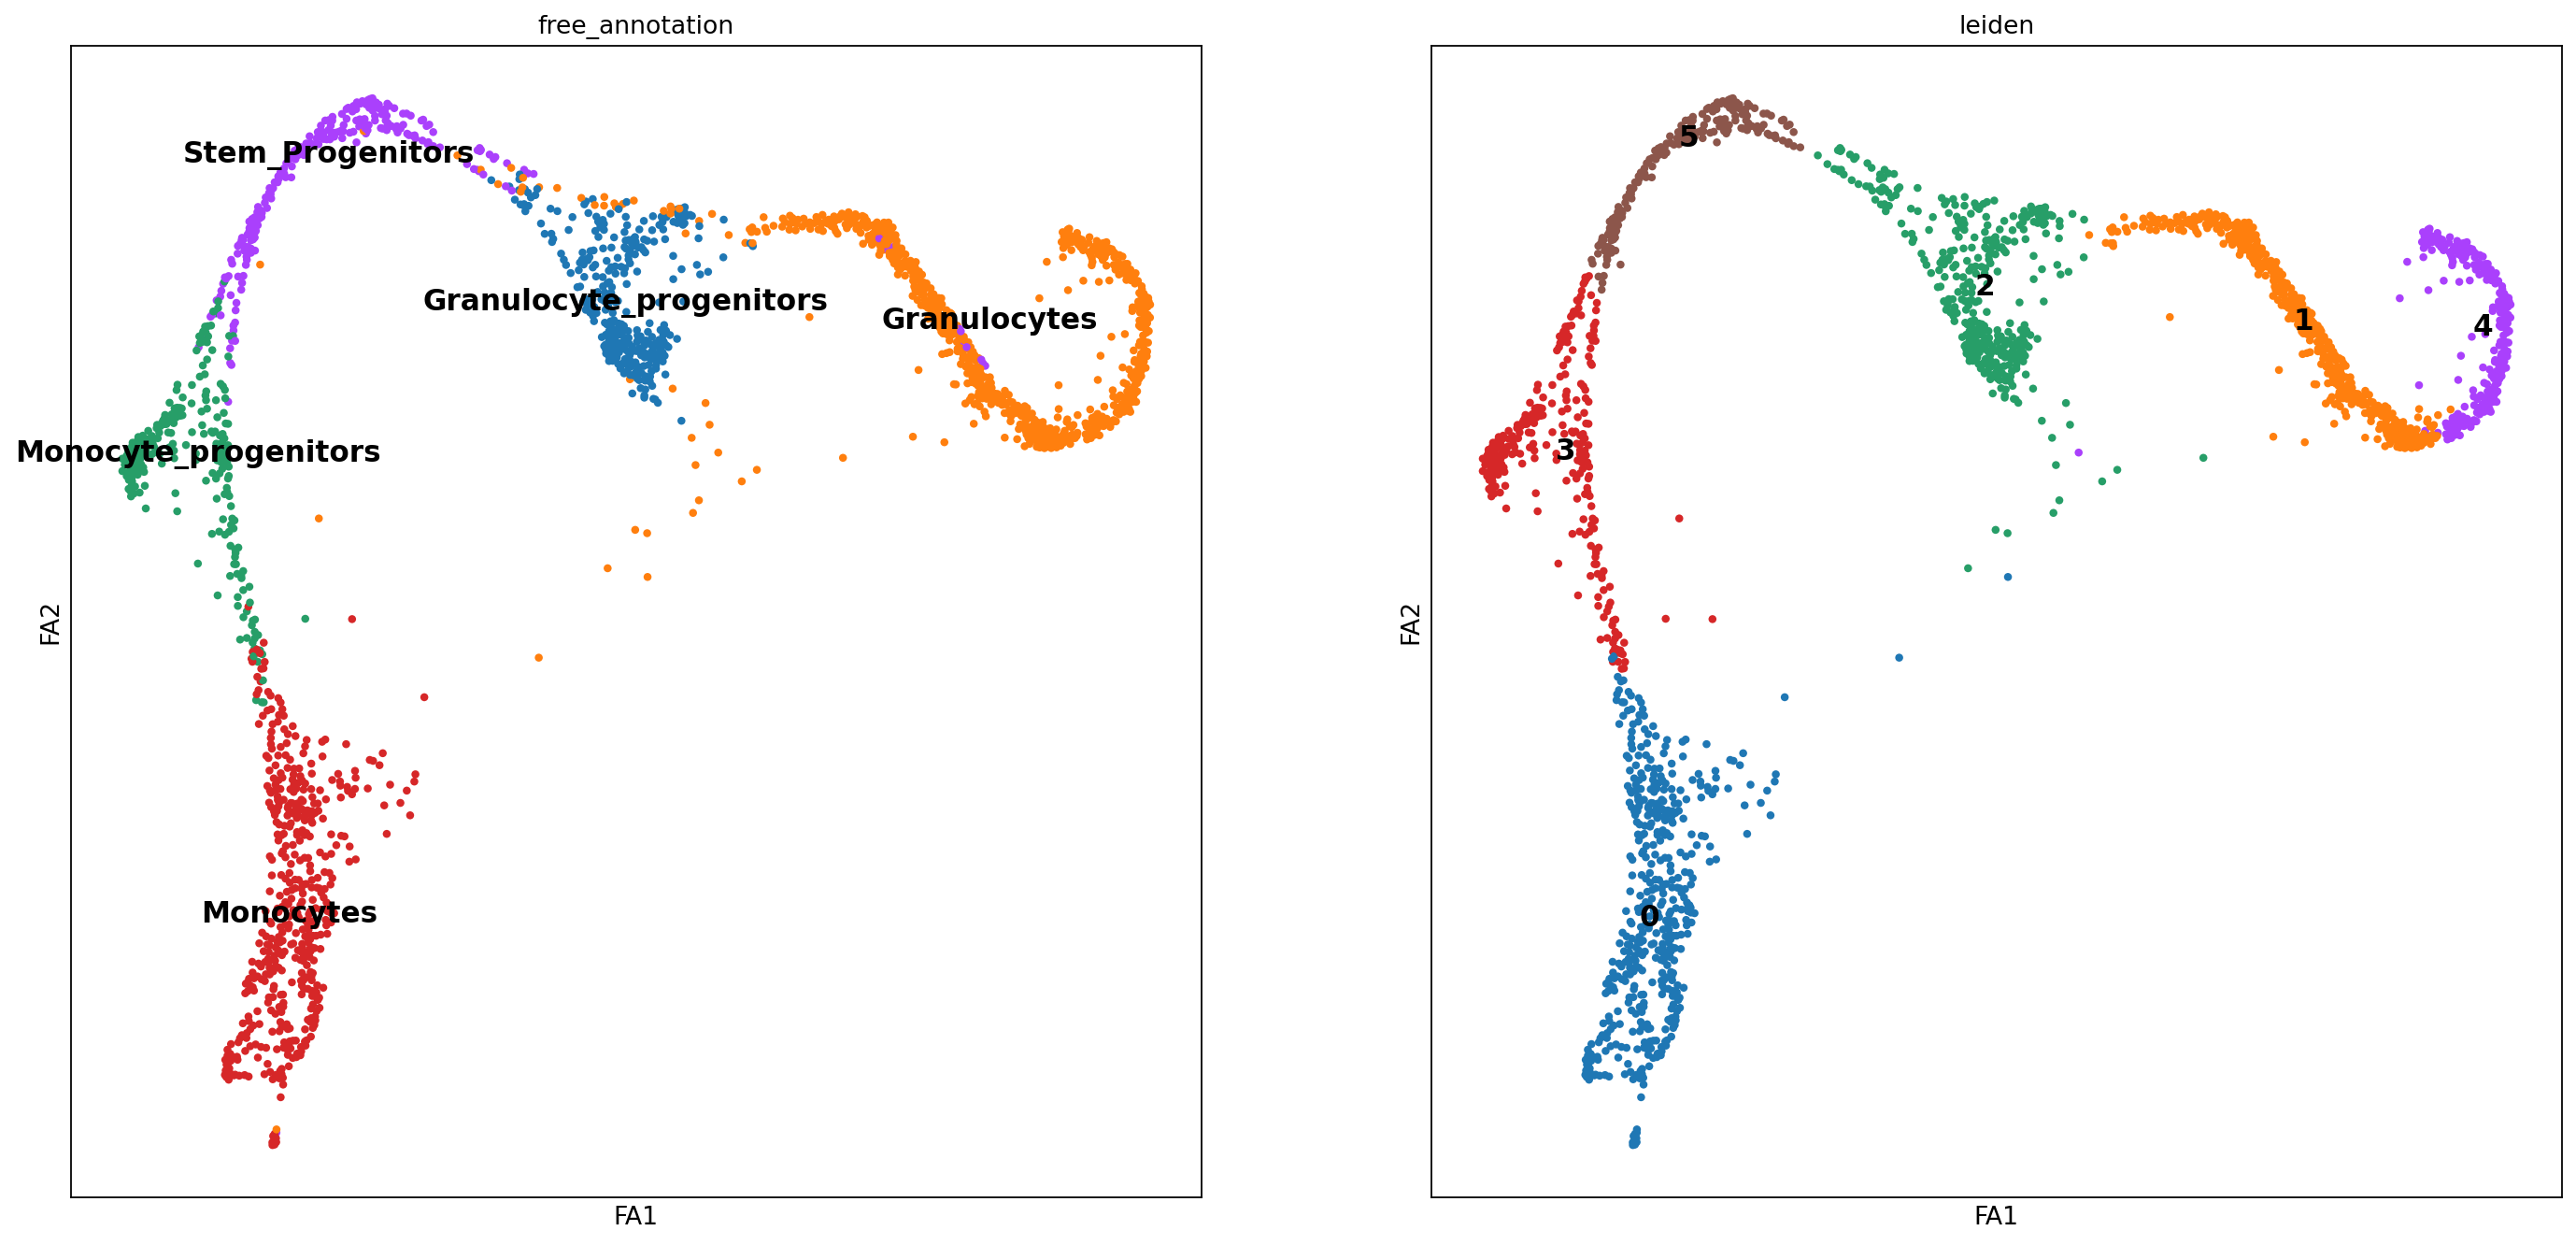

In [20]:
plt.rcParams['figure.figsize'] = [10, 10]

# Re-run and re-plot ForceAtlas2 with it aware of the PAGA relationships
sc.tl.draw_graph(adata, init_pos='paga')
sc.pl.draw_graph(adata, color=['free_annotation', 'leiden'], legend_loc="on data", legend_fontsize=14)

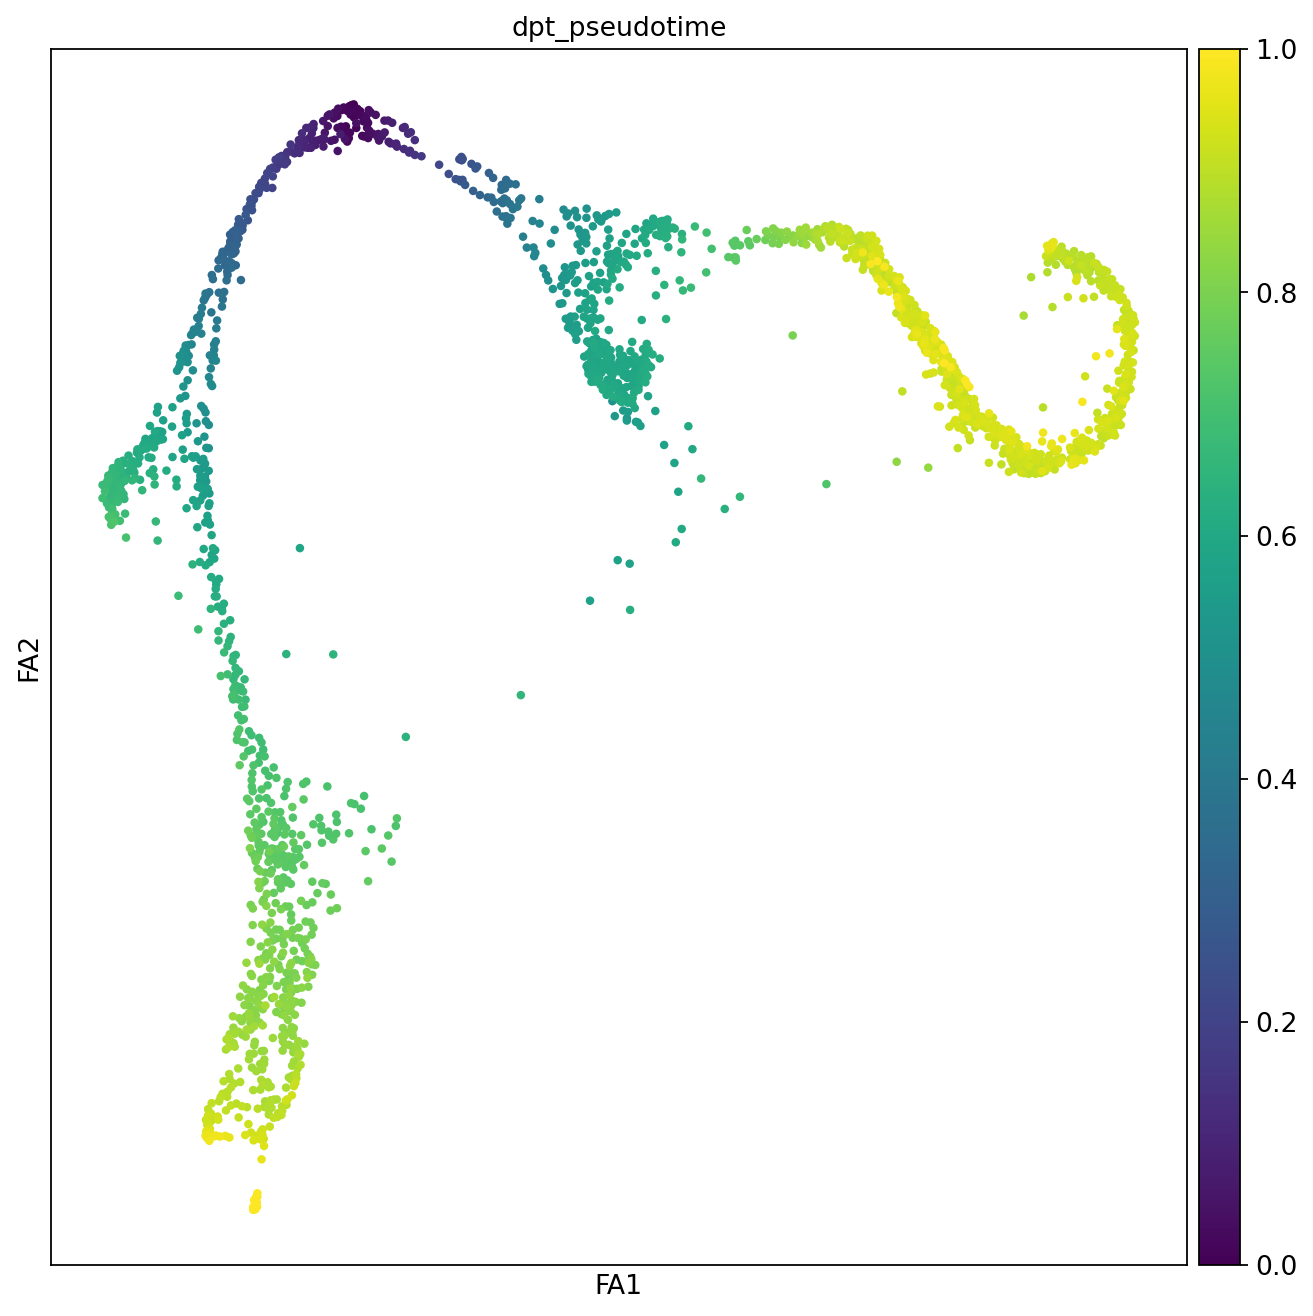

In [21]:
plt.rcParams['figure.figsize'] = [10, 10]

# Set the starting cell cluster to 5 (which corresponds with HSCs)
# This is required so the pseudotime algortihm below
# See https://scanpy.readthedocs.io/en/stable/api/scanpy.tl.dpt.html#scanpy.tl.dpt
# for more usage information on sc.tl.dpt
adata.uns['iroot'] = np.flatnonzero(adata.obs.leiden  == '5')[0]
sc.tl.dpt(adata, n_dcs=7)

# Plot the pseudotime on revised ForceAtlas2 coordinates
sc.pl.draw_graph(adata, color=['dpt_pseudotime'], legend_loc="on data", legend_fontsize=14)

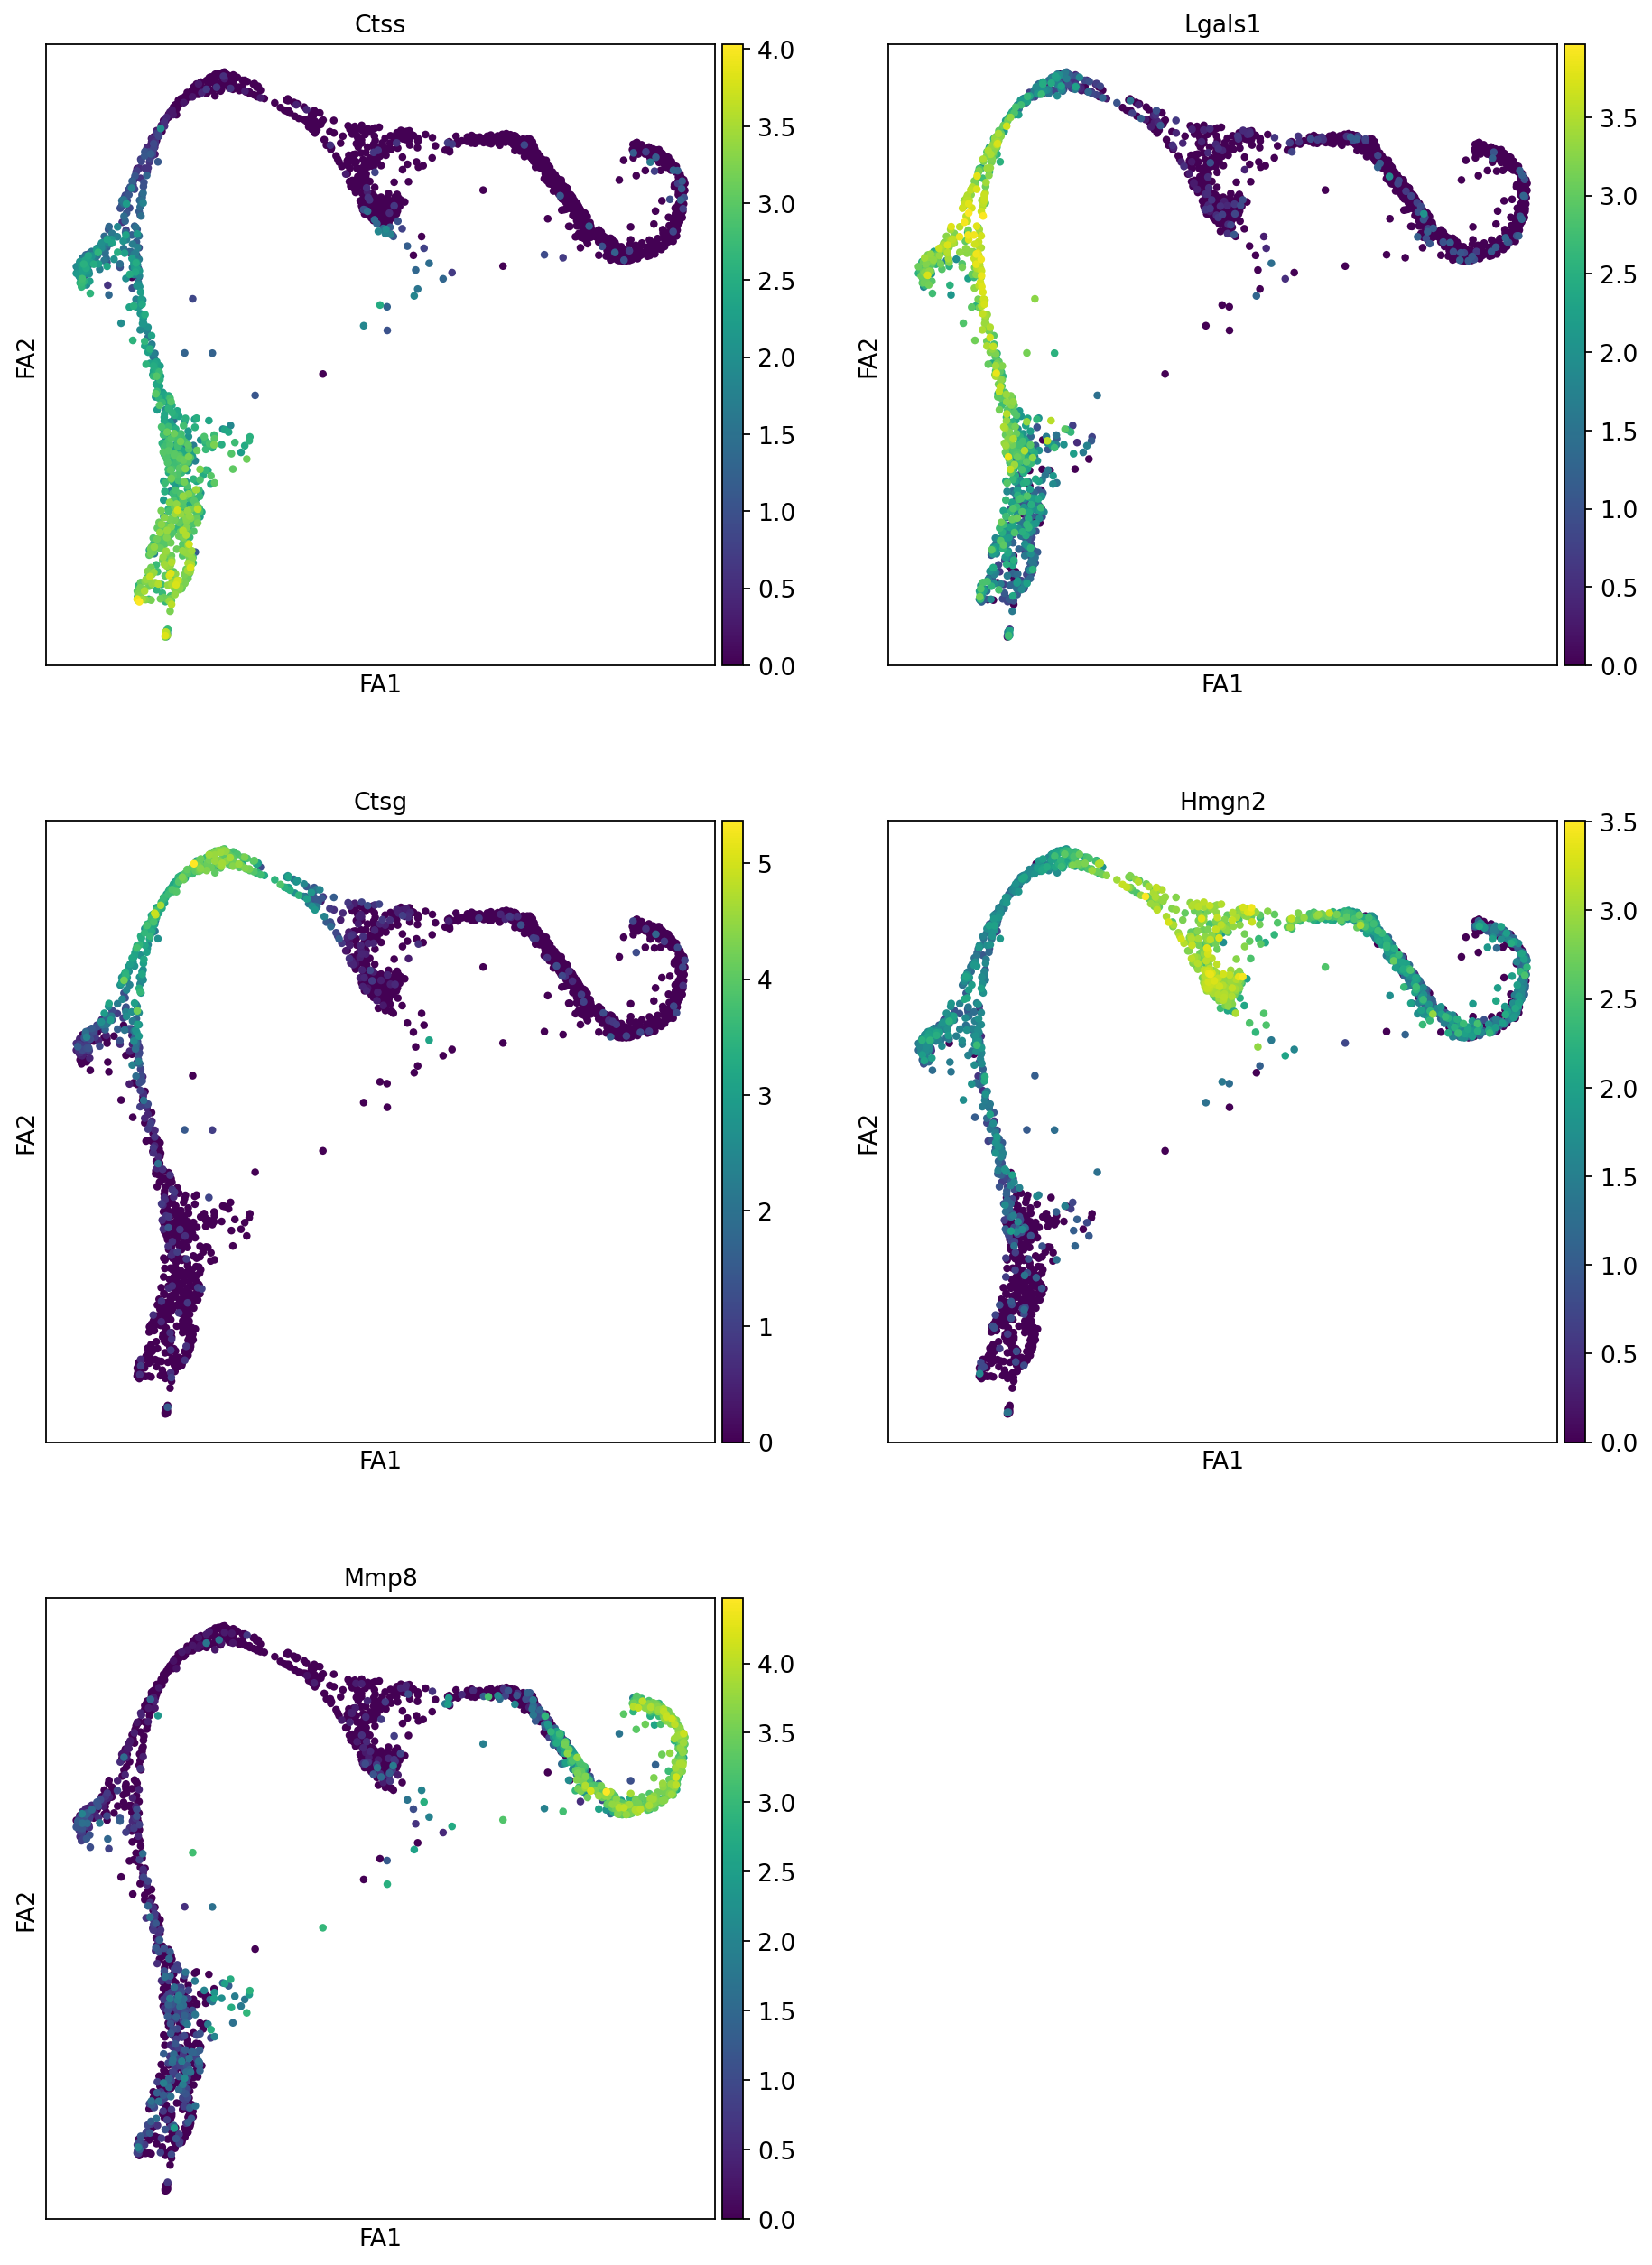

In [22]:
plt.rcParams['figure.figsize'] = [6, 6]
# Plot some differentially expressed genes from above that were along the trajectory
sc.pl.draw_graph(adata, color=["Ctss", "Lgals1", "Ctsg", "Hmgn2", "Mmp8"], legend_loc="on data", legend_fontsize=14, ncols=2)

**Question:** Conceptually, how could you use pesudotime and the PAGA trajectories to to refine your differential gene expression analysis?

**Answer:**

In [23]:
# Write the PAGA loom file to disk for use with velocity
adata.write_loom(os.path.join(pwd, "MACA_bonemarrow_10x_PAGA.loom"))

The loom file will lack these fields:
{'X_diffmap', 'PCs', 'X_draw_graph_fa', 'X_pca'}
Use write_obsm_varm=True to export multi-dimensional annotations


In [24]:
# Write out UMI table and cellular and gene metadata for monocle3 later
# Opening a loom file in R, while possible, has gotten more difficult recently
# as their use has waned and support diminshed by major packages
UMIs = pd.DataFrame(data=adata.layers["matrix"].T.todense(),
                    columns=adata.obs_names, 
                    index=adata.var_names)
UMIs['Genes'] = UMIs.index
UMIs = UMIs.groupby('Genes').sum()
UMIs.to_csv(os.path.join(pwd, 'MACA_bonemarrow_10x.csv'))

adata.obs.to_csv(os.path.join(pwd, 'MACA_bonemarrow_10x_obs.csv'))

adata.var[~adata.var.Gene.duplicated()].to_csv(os.path.join(pwd, 'MACA_bonemarrow_10x_var.csv'))

## Velocyto

RNA velocity is a high-dimensional vector that predicts the future state of individual cells on a timescale of hours. RNA velocity is the time derivative of the gene expression state and can be directly estimated by distinguishing between unspliced and spliced mRNAs in common single-cell RNA sequencing protocols. See Manno et al (2018) _Nature_ for more details

And http://velocyto.org/velocyto.py/index.html for usage information. We highly recommend you read their supplementary note on how the algorithm works. While technical, it lays out their model _very_ clearly. You can find it at https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-018-0414-6/MediaObjects/41586_2018_414_MOESM1_ESM.pdf

### Data ingest

In [ ]:
# Load the loom file in as a velocyto object
vlm = vcy.VelocytoLoom(os.path.join(pwd, "MACA_bonemarrow_10x_PAGA.loom"))

### Explore the velocyto object

In [ ]:
# Print the cellular metadata
vlm.ca

In [ ]:
# Show available metadata columns
vlm.ca.keys()

In [ ]:
# Access a the free_annotation's for the first 5 cells
vlm.ca['free_annotation'][:5]

In [ ]:
# Access the gene metadata
vlm.ra

In [ ]:
# Show available gene metadata
vlm.ra.keys()

In [ ]:
# Access the mean expression of the first 5 genes
vlm.ra['mean'][:5]

In [ ]:
# Access the UMIs array from spliced
vlm.S

In [ ]:
# Access the UMIs array from unspliced
vlm.U

In [ ]:
# Access specific genes from spliced UMIs array from the first 5 cells
vlm.S[[i in ['Mpo', 'Ctsg'] for i in list(vlm.ra['Gene'])],:5]

In [ ]:
# Access specific genes from unspliced UMIs array from the first 5 cells
vlm.U[[i in ['Mpo', 'Ctsg'] for i in list(vlm.ra['Gene'])],:5]

### Normalize and filter spliced and unspliced gene expression

**Note:** The functions may look different from scanpy or Seurat, but this section is conceptually similar to how they both function

In [ ]:
# Tell velocyto what each cell's type is
vlm.set_clusters(vlm.ca['free_annotation'])

In [ ]:
# Plot the fraction of spliced, ambiguous, and unspliced UMIs in each 10x run
# Reads from unspliced pre-mRNA comes from ectopic poly-T priming
vlm.plot_fractions()

In [ ]:
# Normalize spliced and unspliced UMIs, the method is slightly different from scanpy
# and Seurat. Each spliced or unspliced UMI is multipled by a normalization factor, 
# which is the mean number of spliced or unspliced UMIs across all cells divided by 
# each individual cells total spliced or unspliced UMIs. Normalized UMIs are set to
# vlm.S_sz and vlm.U_sz
#
vlm.normalize("S", size=True, log=False)
vlm.normalize("U", size=True, log=False)

In [ ]:
# Filter genes out that have fewer than 30 spliced UMIs across all cells
# or that haved spliced expression in fewer than 20 cells
vlm.score_detection_levels(min_expr_counts=30, min_cells_express=20,
                           min_expr_counts_U=0, min_cells_express_U=0)
vlm.filter_genes(by_detection_levels=True)

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]


# Select the top 2000 genes based on their mean expression and variance
# Winsorizing is a statical transformation that limits extreme values
vlm.score_cv_vs_mean(2000, plot=True,
                     winsorize=True,
                     winsor_perc=(1,99.8),
                     svr_gamma=0.01)
vlm.filter_genes(by_cv_vs_mean=True)

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]

# Filter genes out that have fewer than 25 unspliced UMIs across all cells
# or that haved unspliced expression in fewer than 20 cells
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0,
                           min_expr_counts_U=25, min_cells_express_U=20)

vlm.filter_genes(by_detection_levels=True)

In [ ]:
# Normalize by total cell counts and log-transform the data
# The log-transformed values are stored in vlm.S_norm and vlm.U_norm
vlm.normalize_by_total(min_perc_U=0.5, plot=True)

# Adjust the splice count based on the relationship between total spliced and unspliced UMIs
vlm.adjust_totS_totU(normalize_total=True, fit_with_low_U=False, svr_C=1, svr_gamma=1e-04)

**Question:** How does the number of spliced UMIs compare with unspliced UMIs?

**Answer:**

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]

# Run principle component analysis and plot each components ratio of total variance
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.0055))[0][0]
vlm.pcs[:,1] *= -1 # flip for consistency with previous version

In [ ]:
# For the preparation of the gamma fit we smooth the data using a kNN neighbors
# pooling approach. kNN neighbors can be calculated directly in gene expression
# space or reduced PCA space
#
# Creates smoothed splice and unspliced expression matrices on vlm.Sx and vlm.Ux
k=500
vlm.knn_imputation(n_pca_dims=n_comps,k=k, balanced=True,
                   b_sight=np.minimum(k*8, vlm.S.shape[1]-1),
                   b_maxl=np.minimum(k*4, vlm.S.shape[1]-1),
                   n_jobs=4)

In [ ]:
# Normalize to median cell sizes and then fit gamma to genes that
# survived the filtering step run. Gamma represents the rate of degredation
vlm.normalize_median()
vlm.fit_gammas(maxmin_perc=[2,95], limit_gamma=True)

### Model RNA velocity with first order rate kinetics

In [ ]:
# Predict U given the fitted gammas
vlm.predict_U()

# Calculate RNA velocity
vlm.calculate_velocity()

# Calculate the change in gene expression (dS/dt) assuming constant velocity
vlm.calculate_shift(assumption="constant_velocity")

# Extrapolate gene expression based on velocity
vlm.extrapolate_cell_at_t(delta_t=1)

# Set the display embedding as the first 2 principle components
vlm.Pcs = np.array(vlm.pcs[:,:2], order="C")

### Calculate new position of cells in chosen embedding

**Note:** In this case, we are going to display the cells on their first 2 principle components

In [ ]:
# Estimate the probability a cell represents a differentiation starting point
vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="log", psc=1, n_neighbors=150, knn_random=True, sampled_fraction=1)

In [ ]:
# Use the transition probability to project the velocity direction on the embedding
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=True)

In [ ]:
# Calculate the vetor field for how cell expression changes across the embedding
vlm.calculate_grid_arrows(smooth=0.9, steps=(25, 25), n_neighbors=100)

In [ ]:
# Plot the cells in the first two principle 
plt.figure(None,(10,10))
vlm.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":70, "rasterized":True},
                     min_mass=2.9, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.35, scale_type="absolute")
plt.gca().invert_xaxis()
for i in vlm.ca["free_annotation"]:
    Pcs_m = np.median(vlm.Pcs[vlm.ca["free_annotation"] == i, :], 0)
    plt.text(Pcs_m[0], Pcs_m[1], str(vlm.ca["free_annotation"][vlm.ca["free_annotation"] == i][0]),
             fontsize=13, bbox={"facecolor":"w", "alpha":0.6})
plt.axis("off")
plt.axis("equal");

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]

# Plot the cells that are upregulating (above the line) or downregulating
# each of the listed genes (from earlier differential gene expression analysis)
# The cells are colored by their annotation identity (as above).
vlm.plot_phase_portraits(["Ctss", "Lgals1", "Ctsg", "Hmgn2", "Mmp8"])

**Question:** Do the up- and down-regulation scores in the phase plots above make sense? Hint: It may be useful to compare with leiden cluster expression from earlier.

**Answer:**

### Find genes enriched as a function of pseudotime

In [ ]:
# Set the total number of cells
n_cells = vlm.cluster_ix.shape[0]

# Number of cells per cluster
sizes = np.bincount(vlm.cluster_ix)

# Number of nonzero values per cluster
nnz = aggregate(vlm.cluster_ix, (vlm.Sx_sz>0).astype(float), func="sum", axis=1)

# Mean value per cluster
means = aggregate(vlm.cluster_ix, vlm.Sx_sz, func="mean", axis=1)

# Non-zeros and means over all cells
nnz_overall, means_overall = (vlm.Sx_sz>0).sum(1), vlm.Sx_sz.mean(1)

# Scale by number of cells
f_nnz = nnz / sizes
f_nnz_overall = nnz_overall / n_cells

# Means and fraction non-zero values in other clusters (per cluster)
means_other = ((means_overall * n_cells)[None].T - (means * sizes)) / (n_cells - sizes)
f_nnz_other = ((f_nnz_overall * n_cells)[None].T - (f_nnz * sizes)) / (n_cells - sizes)

enrichment = (f_nnz + 0.1) / (f_nnz_overall[None].T + 0.1) * (means + 0.01) / (means_overall[None].T + 0.01)

In [ ]:
# Create dictionary of enriched genes
enriched = {}
for i in range(enrichment.shape[1]):
    tmp = pd.DataFrame([enrichment[:,i][np.argsort(enrichment[:,i])[::-1]][:350],vlm.ra["Gene"][np.argsort(enrichment[:,i])[::-1]][:350]]).T
    tmp.rename({0: 'score', 1: 'gene'}, inplace=True, axis=1)
    tmp.index = tmp.gene
    enriched[i] = tmp

In [ ]:
# Print table of top 25 enriched genes per identity
# 0 = Granulocyte progenitors, 1 = Granulocytes, 2 = Monocyte progenitors
# 3 = Monocytes, 4 = HSCs
enriched[4][:25]

In [ ]:
plt.figure(None,(10,10))
vlm.plot_expression_as_color('Ak4', imputed=True, which_tsne="Pcs")
plt.gca().invert_xaxis()

plt.figure(None,(10,10))
vlm.plot_expression_as_color('Chit1', imputed=True, which_tsne="Pcs")
plt.gca().invert_xaxis()

plt.figure(None,(10,10))
vlm.plot_expression_as_color('Tmem45a2', imputed=True, which_tsne="Pcs")
plt.gca().invert_xaxis()

plt.figure(None,(10,10))
vlm.plot_expression_as_color('Gria3', imputed=True, which_tsne="Pcs")
plt.gca().invert_xaxis()

plt.figure(None,(10,10))
vlm.plot_expression_as_color('Mx1', imputed=True, which_tsne="Pcs")
plt.gca().invert_xaxis()

### Further exploration of the velocyto object

In [ ]:
# Log-transformed, normalized spliced UMIs
vlm.S_norm

In [ ]:
# Normalized spliced UMIs
vlm.S_sz 

In [ ]:
# Smoothed spliced UMIs
vlm.Sx

In [ ]:
# Smoothed, normalized spliced UMIs
vlm.Sx_sz

In [ ]:
# Smoothed, normalized spliced UMIs adjusted based on their RNA velocity
vlm.Sx_sz_t

In [ ]:
# Fit gammas for each gene
vlm.gammas

In [ ]:
# Predicted unspliced UMIs based on RNA velocities
vlm.Upred

In [ ]:
# Coordinates for the visualization (first 2 principle components)
vlm.embedding

In [ ]:
# Shift for each cell based on predicted future transcriptome
vlm.delta_embedding

In [ ]:
# Per cell per gene RNA velocities as dS/dt
vlm.delta_S

**Question:** Conceptually, how could you use the embedding shifts or RNA velocities to refine your differntial gene expression analysis?

**Answer:**